# Avaliação 01
___
## Modelo de RNA com dados de potência elétrica

Requisitos:
* Erro Percentual Absoluto Máximo menor que 10%
* Erro Percentual Absoluto Médio menor que 5%

**Disciplina:** Automação Inteligênte

**Autor:** Miguel Marques Ferreira

**GitHub:** https://github.com/Miguel-mmf

## Bibliotecas

In [58]:
import pandas as pd
import numpy as np
# import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
# rcParams.update(
#     {
#         'figure.figsize':(16,5),
#         'figure.facecolor':'white',
#         'font.size':'12',
#         'axes.grid': True,
#         'axes.grid.axis': 'both',
#         # 'text.usetex' : True,
#         # 'font.family' : 'serif',
#         # 'font.serif' : 'cm'
#     }
# )
import seaborn as sns
from tqdm import tqdm

# from sklearn.preprocessing import MinMaxScaler
# from distutils.dir_util import mkpath
# from sklearn.metrics import (
#     mean_absolute_error,
#     mean_absolute_percentage_error,
#     mean_squared_error,
#     max_error
# )
# from sklearn.model_selection import train_test_split
# from kerastuner import Objective
# from kerastuner.tuners import RandomSearch, BayesianOptimization

%matplotlib inline

## Leitura dos dados

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# data = pd.read_csv('/content/drive/MyDrive/9º COMP. OPTATIVA/Automação Inteligente 2023.2/dados_demanda.csv', sep=';')
data = pd.read_csv('https://raw.githubusercontent.com/Miguel-mmf/smart-automation/main/data/dados_demanda.csv?token=GHSAT0AAAAAACK2YQPX567YYZ4H4O7NXFG6ZOPMERA', sep=';', decimal=',')
data['TEMPO'] = data[['DIA','MES','ANO','HORA','MINUTO']].apply(
    lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3],minute=x[4]),
    axis=1
)
data.drop(columns=['Unnamed: 6','DIA','MES','ANO','HORA','MINUTO'], inplace=True, errors='ignore')
data.rename(columns={'JPS_12B1':'POTENCIA'},inplace=True)
# data.set_index('TEMPO', inplace=True)
data.head()

/tmp/ipykernel_2095546/3752462651.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3],minute=x[4]),


POTENCIA               TEMPO
0       7.9 2008-01-01 00:00:00
1       7.7 2008-01-01 00:15:00
2       7.7 2008-01-01 00:30:00
3       7.4 2008-01-01 00:45:00
4       7.4 2008-01-01 01:00:00

In [8]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210432 entries, 0 to 210431
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   POTENCIA  210432 non-null  float64       
 1   TEMPO     210432 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.2 MB


## Cálculo da Energia (E)

In [9]:
data['ENERGIA'] = None
pbar = tqdm(total=len(data['TEMPO'].dt.strftime('%Y-%m-%d').unique()), leave=False)
for d in data['TEMPO'].dt.strftime('%Y-%m-%d').unique():
    aux = data[data['TEMPO'].dt.strftime('%Y-%m-%d') == d].copy()
    start_i = aux.index[0]
    end_i = aux.index[-1]
    aux['POTENCIA'] = aux['POTENCIA']*0.25
    data.loc[start_i:end_i, 'ENERGIA'] = aux['POTENCIA'].cumsum()
    # aux[['POTENCIA', 'POTENCIA(K-1)', 'POTENCIA(K-2)', 'POTENCIA(K-3)', 'POTENCIA(K-4)']] = aux[['POTENCIA','POTENCIA(K-1)', 'POTENCIA(K-2)', 'POTENCIA(K-3)', 'POTENCIA(K-4)']]*0.25
    # for shift in range(0,5):
    #     if shift == 0:
    #         data.loc[start_i:end_i, 'ENERGIA'] = aux['POTENCIA'].cumsum()
    #     else:
    #         data.loc[start_i:end_i, f'ENERGIA(K-{shift})'] = aux[f'POTENCIA(K-{shift})'].cumsum()
    
    pbar.update()

100%|█████████▉| 2191/2192 [02:29<00:00, 14.46it/s]

In [10]:
data.head(3)

POTENCIA               TEMPO ENERGIA
0       7.9 2008-01-01 00:00:00   1.975
1       7.7 2008-01-01 00:15:00     3.9
2       7.7 2008-01-01 00:30:00   5.825

<Axes: >

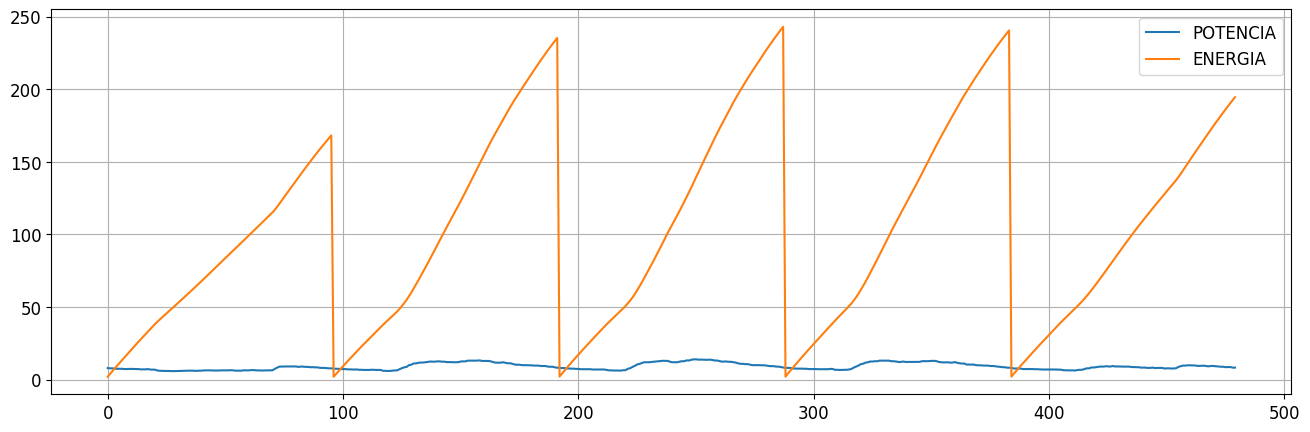

In [11]:
data[data['TEMPO'].dt.strftime('%Y-%m-%d') <= '2008-01-05'][['POTENCIA','ENERGIA']].plot()

## Cálculo da Taxa de Crescimento de Energia (ΔE)

In [20]:
data['TAXA_ENERGIA'] = data['ENERGIA'].diff()
data['TAXA_ENERGIA'].fillna(0, inplace=True)

<Axes: >

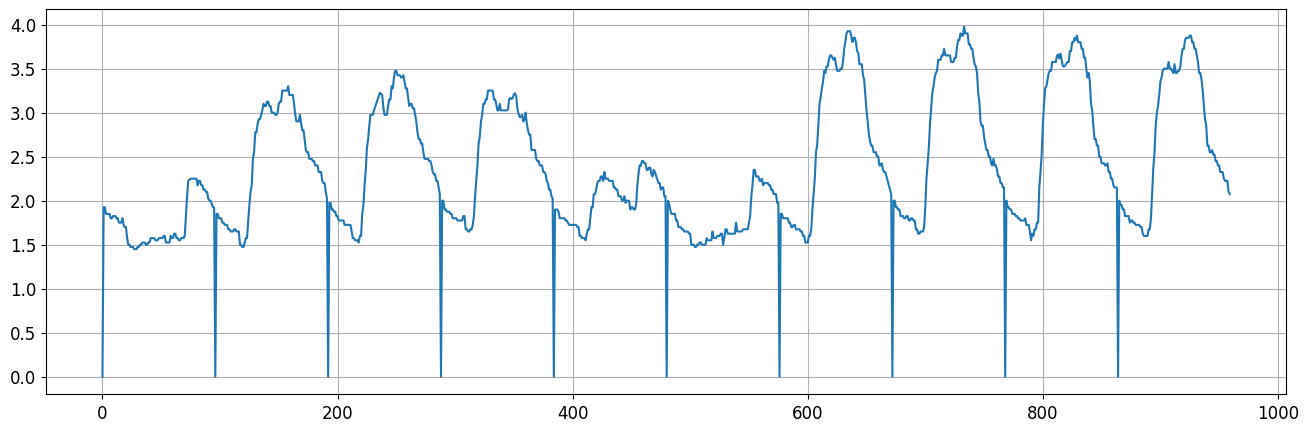

In [21]:
data['TAXA_ENERGIA'].mask(data['TAXA_ENERGIA']<0,0, inplace=True)
data[data['TEMPO'].dt.strftime('%Y-%m-%d') <= '2008-01-10']['TAXA_ENERGIA'].plot()

## Máximo diário e semanal

In [23]:
data.set_index('TEMPO', inplace=True)

In [36]:
max_semanal = data.resample('W').max() #agg(['max'])
# max_diaria = data.resample('D').agg(['max'])

Text(0.5, 0, 'Tempo')

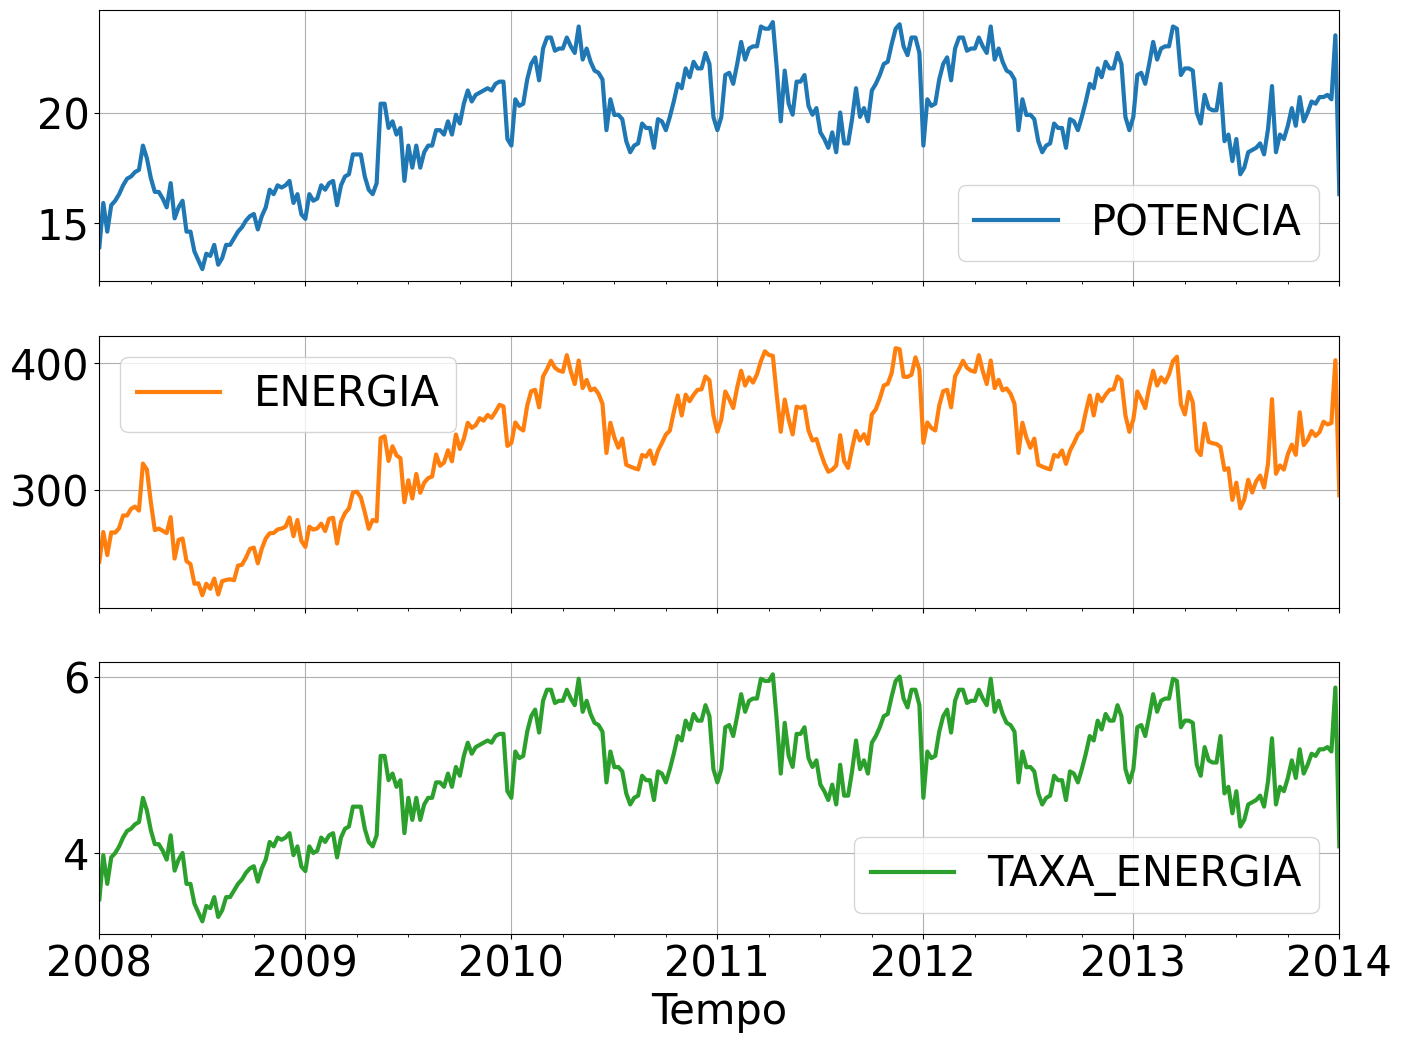

In [38]:
max_semanal.plot(subplots=True, figsize=(16,12), sharex=True, linewidth=3)
plt.xlabel('Tempo')
# plt.ylabel('Potência Máxima')
# plt.title('Potência Máxima Semanal')

## Média por dia da semana

In [14]:
data['weekday'] = [day.weekday() for day in data.index]
print(pd.unique(data.weekday))

[1 2 3 4 5 6 0]


In [15]:
data_weekday = data.groupby(by='weekday').mean()
data_weekday.index = ['Segunda-Feira','Terça-Feira','Quarta-Feira','Quinta-feira','Sexta-Feira','Sabado','Domingo']
data_weekday

POTENCIA
Segunda-Feira  13.266084
Terça-Feira    13.339311
Quarta-Feira   13.471313
Quinta-feira   13.433887
Sexta-Feira    12.982430
Sabado         10.257191
Domingo         9.327263

Text(0.5, 1.0, 'Potência Média por Dia da Semana')

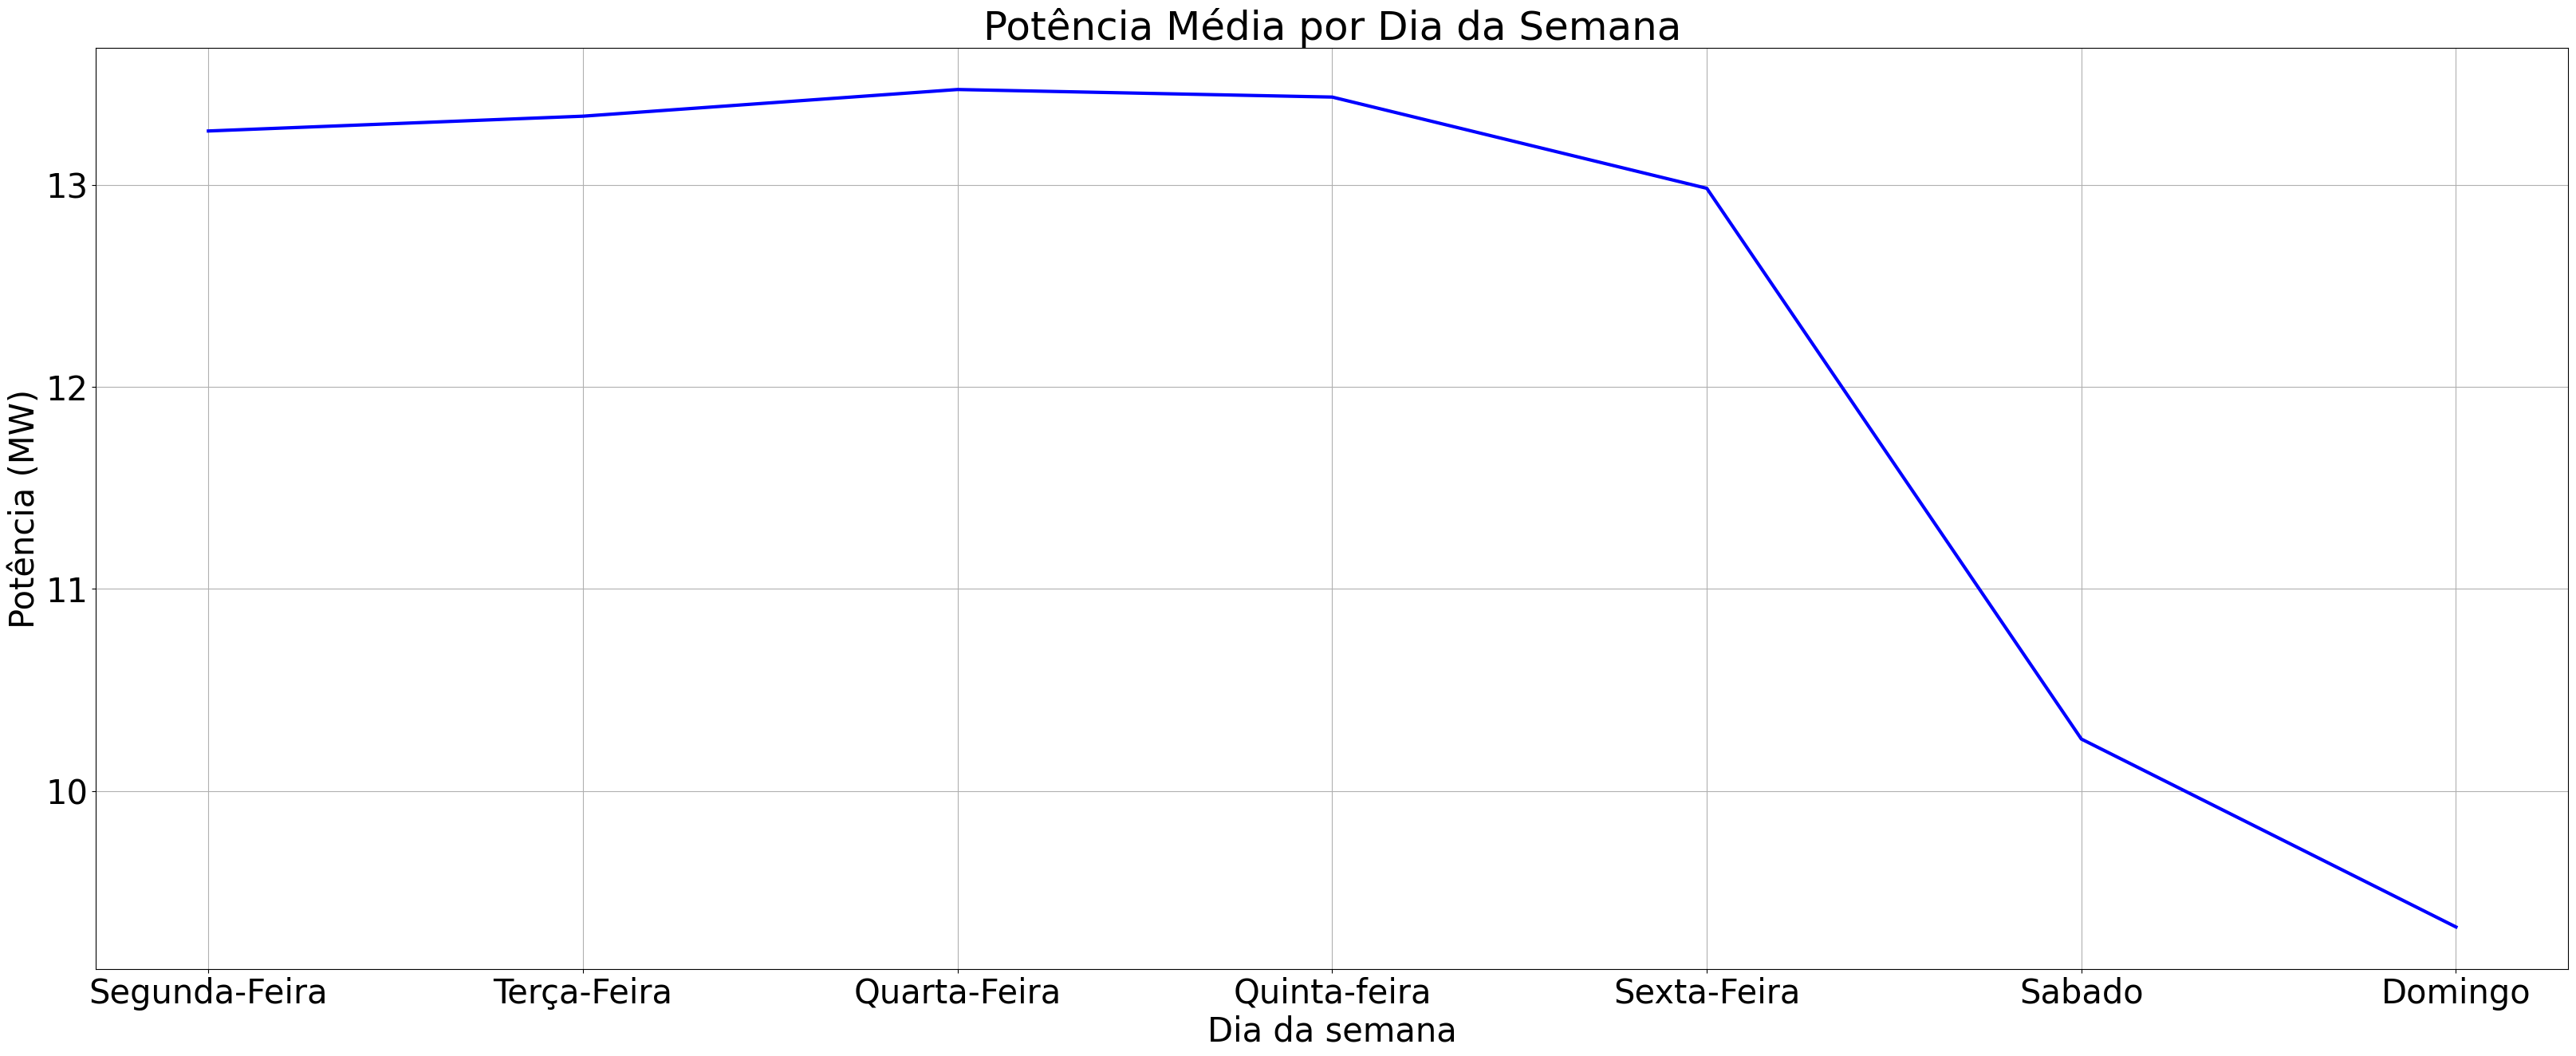

In [16]:
plt.figure(figsize=(40,15), dpi=100)
plt.rc('font', size=30)
plt.grid(True)
plt.plot(data_weekday, lw=3, color='b')
plt.xlabel('Dia da semana')
plt.ylabel('Potência (MW)')
plt.title('Potência Média por Dia da Semana')

## Perfil diário

### Todo o conjunto de dados

In [26]:
data['hour:minute'] = [f'{x.hour}:{x.minute}' for x in data.index]

perfil_horario = pd.DataFrame(index=pd.date_range(start ='2018-01-01 00:00:00',end ='2018-01-01 23:59:59', freq ='15min'))
_means = list()
_std = list()
_median = list()

for h in range(0, 24):
    for m in range(0,60,15):
        _means.append(data.groupby(by='hour:minute').get_group(f'{h}:{m}')['POTENCIA'].mean())
        _std.append(data.groupby(by='hour:minute').get_group(f'{h}:{m}')['POTENCIA'].std())
        _median.append(data.groupby(by='hour:minute').get_group(f'{h}:{m}')['POTENCIA'].median())

perfil_horario['POTENCIA_media'] = _means
perfil_horario['POTENCIA_desvio'] = _std
perfil_horario['POTENCIA_mediana'] = _median

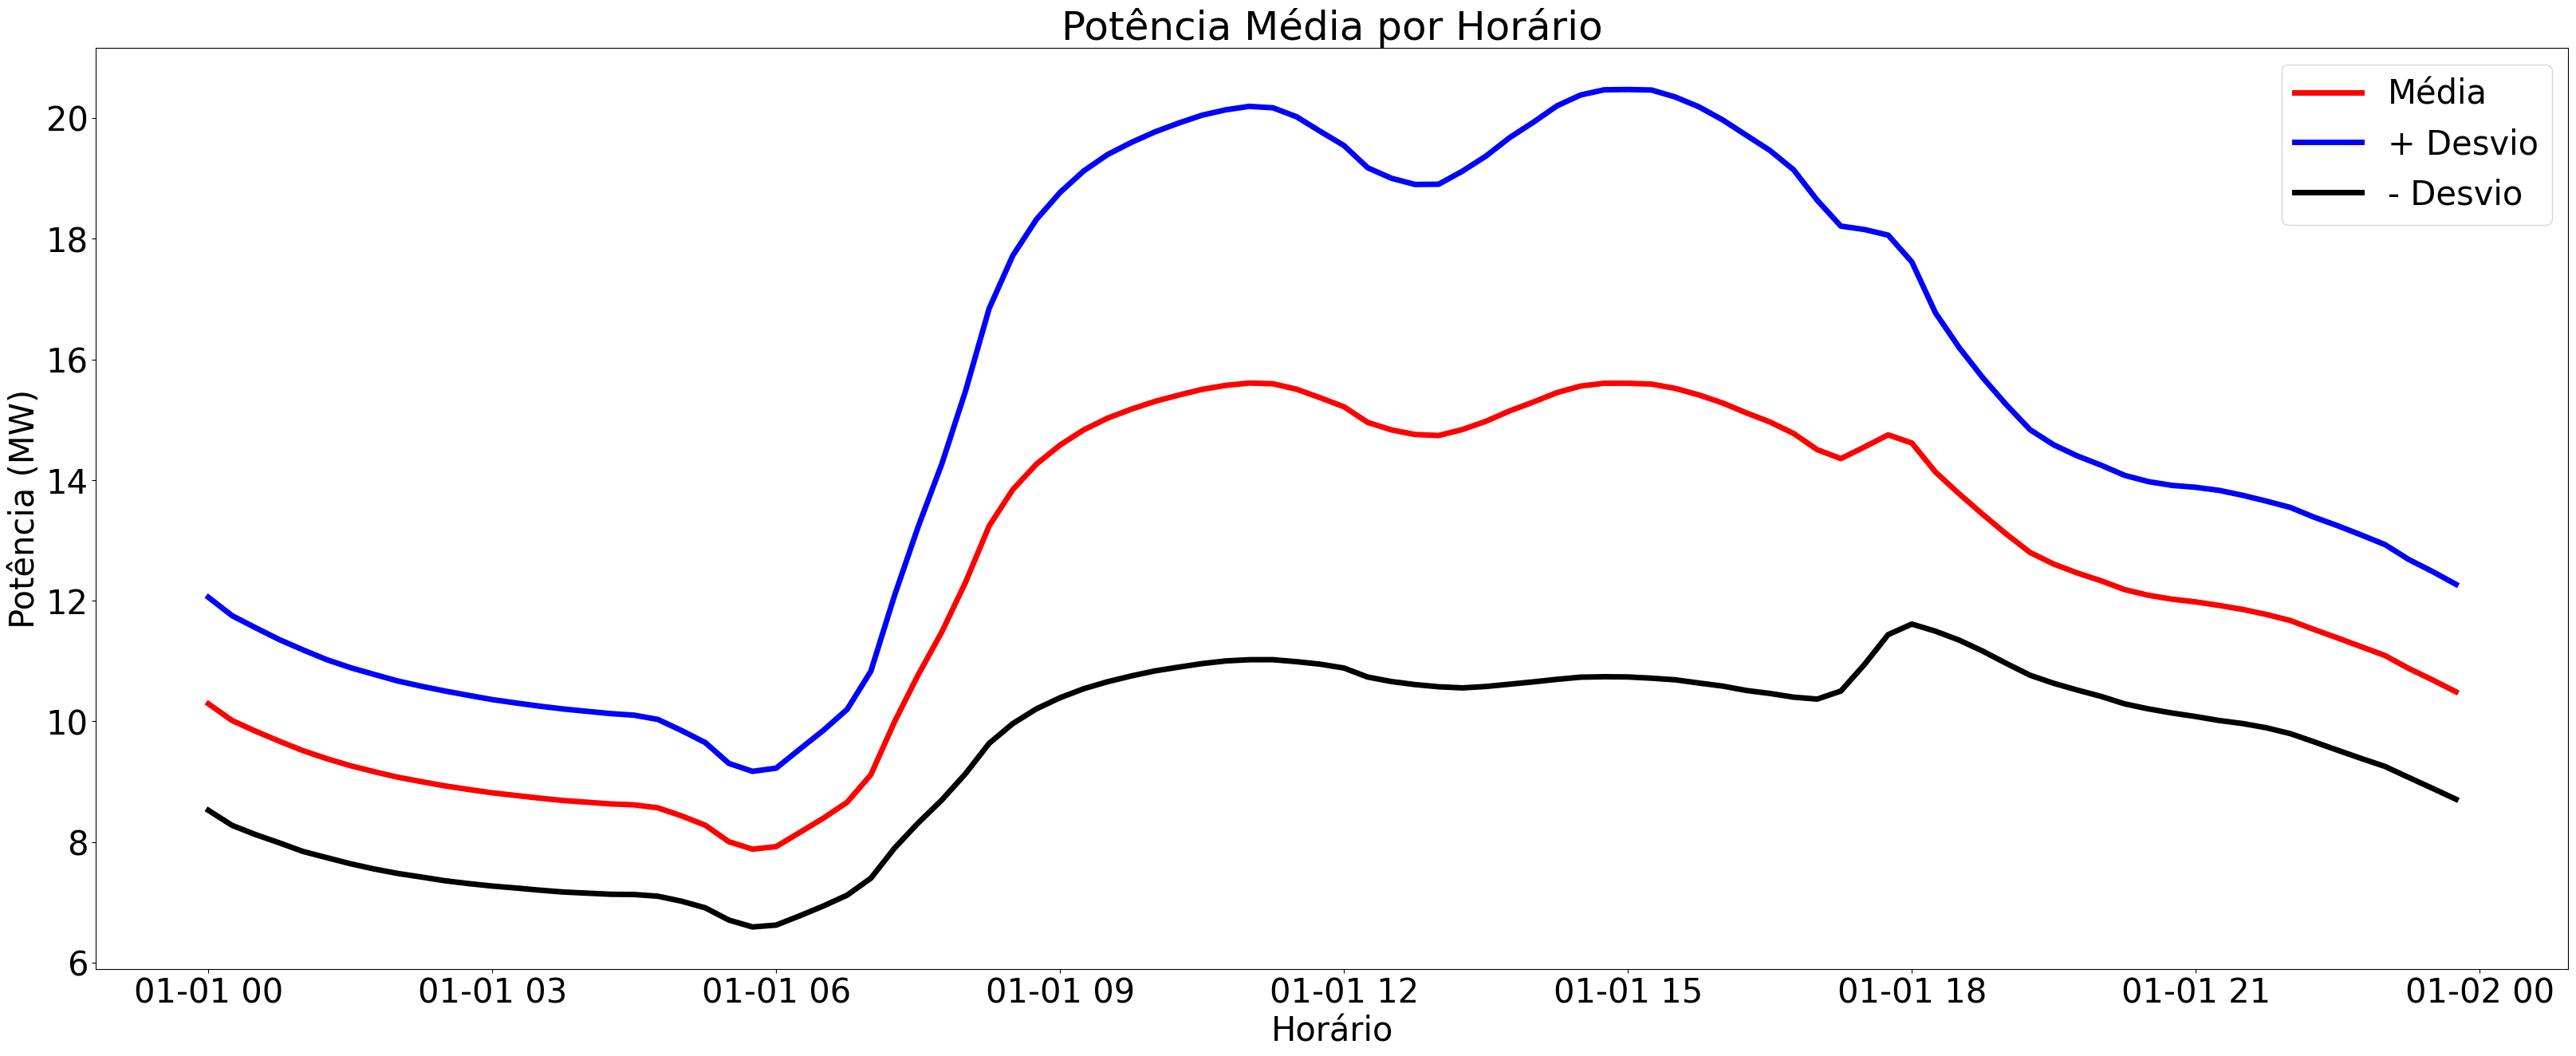

In [27]:
fig, ax = plt.subplots(1,1,figsize=(40,15), dpi=100)

ax.plot(perfil_horario[['POTENCIA_media']], lw=5, color='red', label='Média')
ax.plot(perfil_horario['POTENCIA_media'] + perfil_horario['POTENCIA_desvio'], lw=5, color='blue', label='+ Desvio')
ax.plot(perfil_horario['POTENCIA_media'] - perfil_horario['POTENCIA_desvio'], lw=5, color='black', label='- Desvio')
ax.set_xlabel('Horário')
ax.set_ylabel('Potência (MW)')
ax.set_title('Potência Média por Horário')
ax.legend()
ax.grid()

Text(0.5, 1.0, 'Potência Média por Horário')

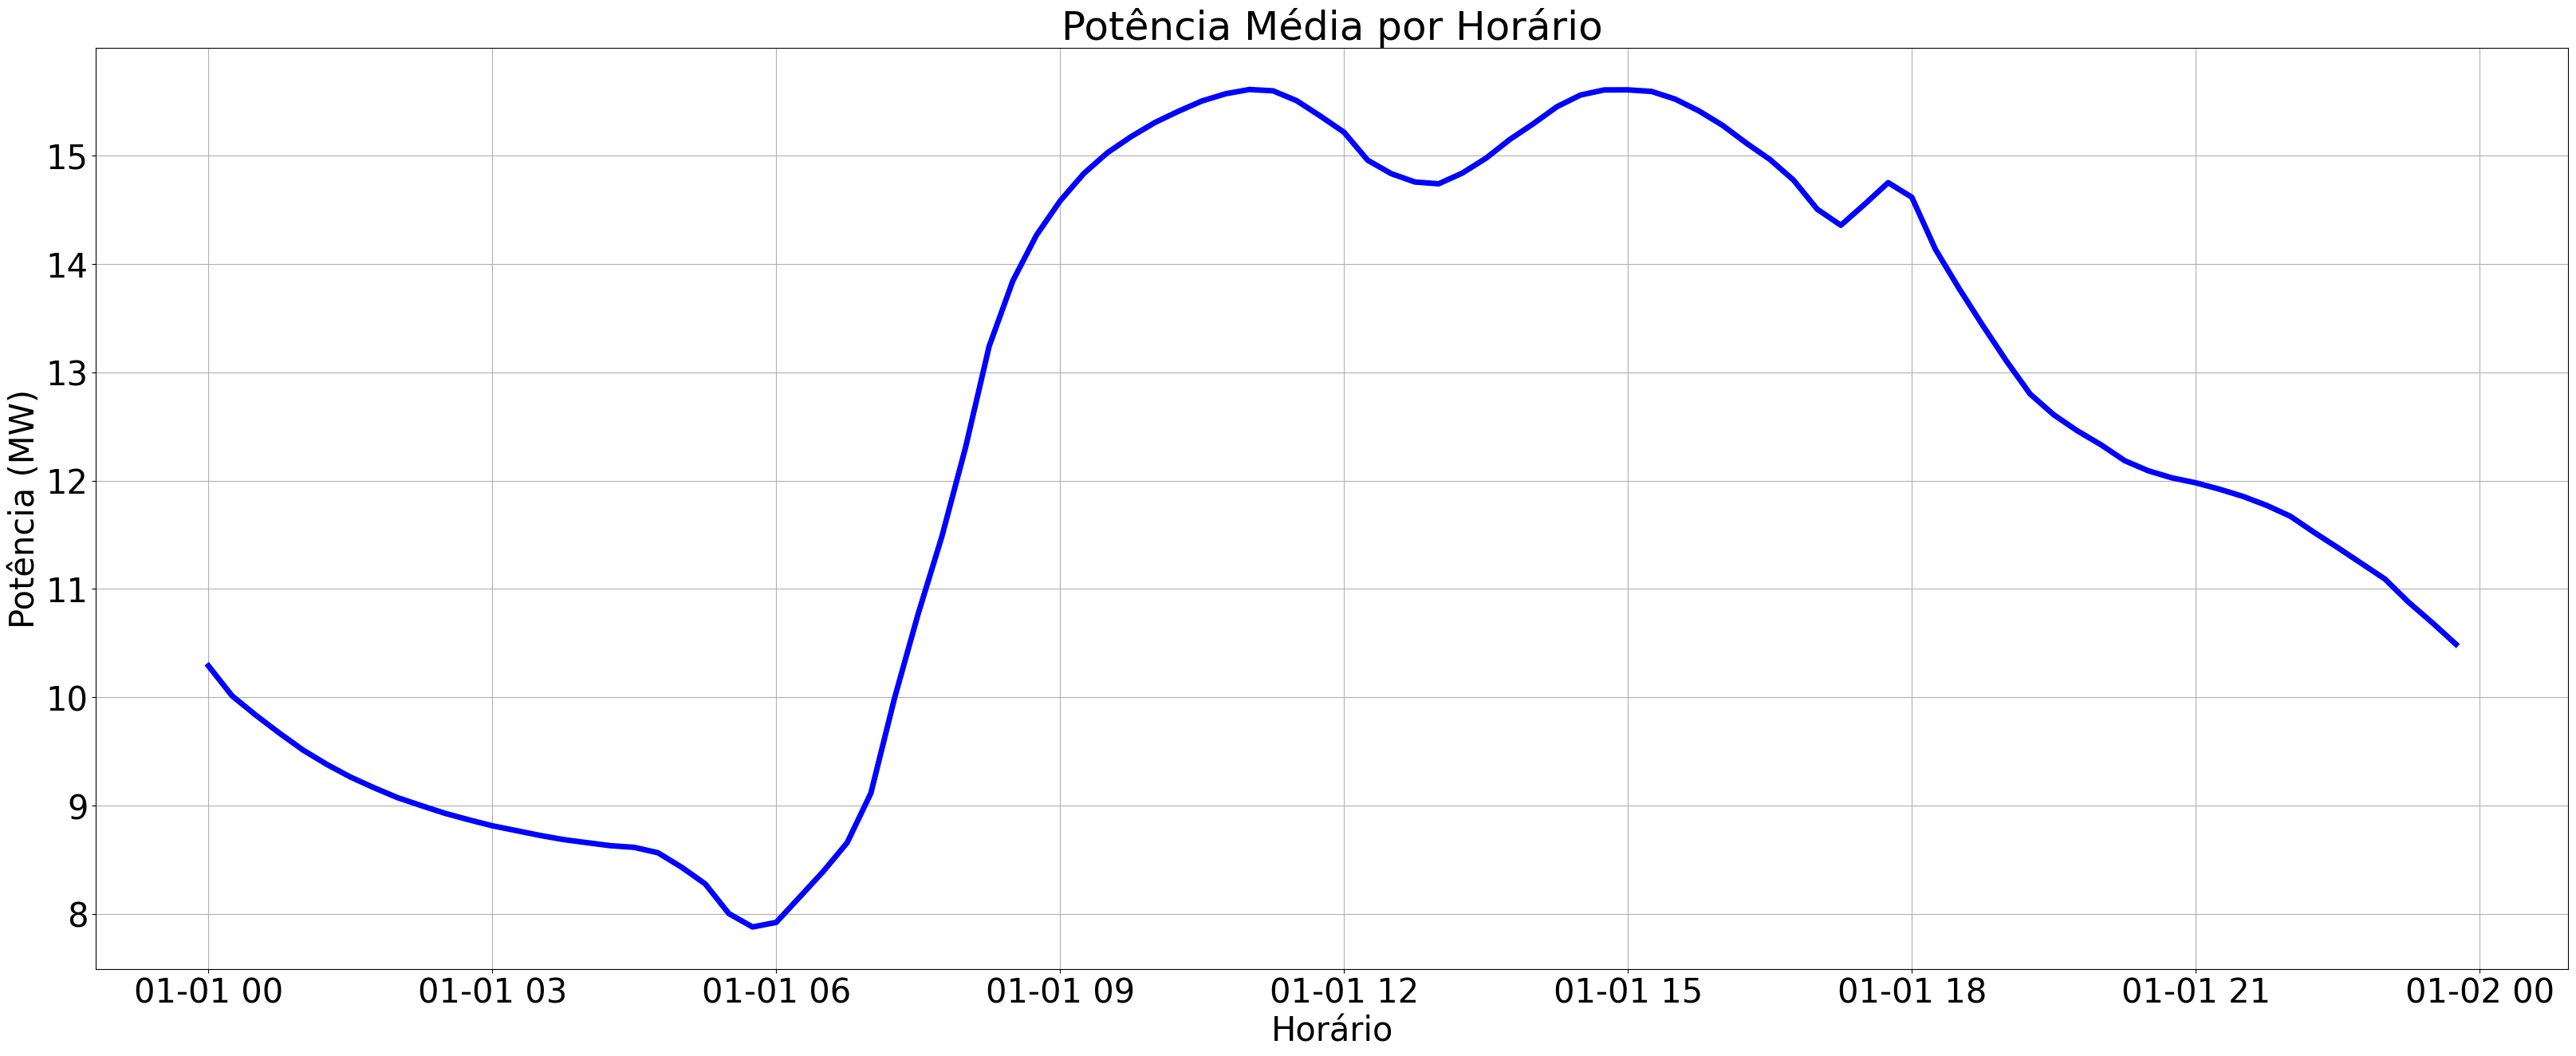

In [28]:
plt.figure(figsize=(40,15), dpi=100)
plt.rc('font', size=30)
plt.grid(True)
plt.plot(perfil_horario[['POTENCIA_media']], lw=5, color='b', label='Média')
plt.xlabel('Horário')
plt.ylabel('Potência (MW)')
plt.title('Potência Média por Horário')

### Por ano

In [29]:
print(data.index.max().year)
print(data.index.min().year)

2013
2008


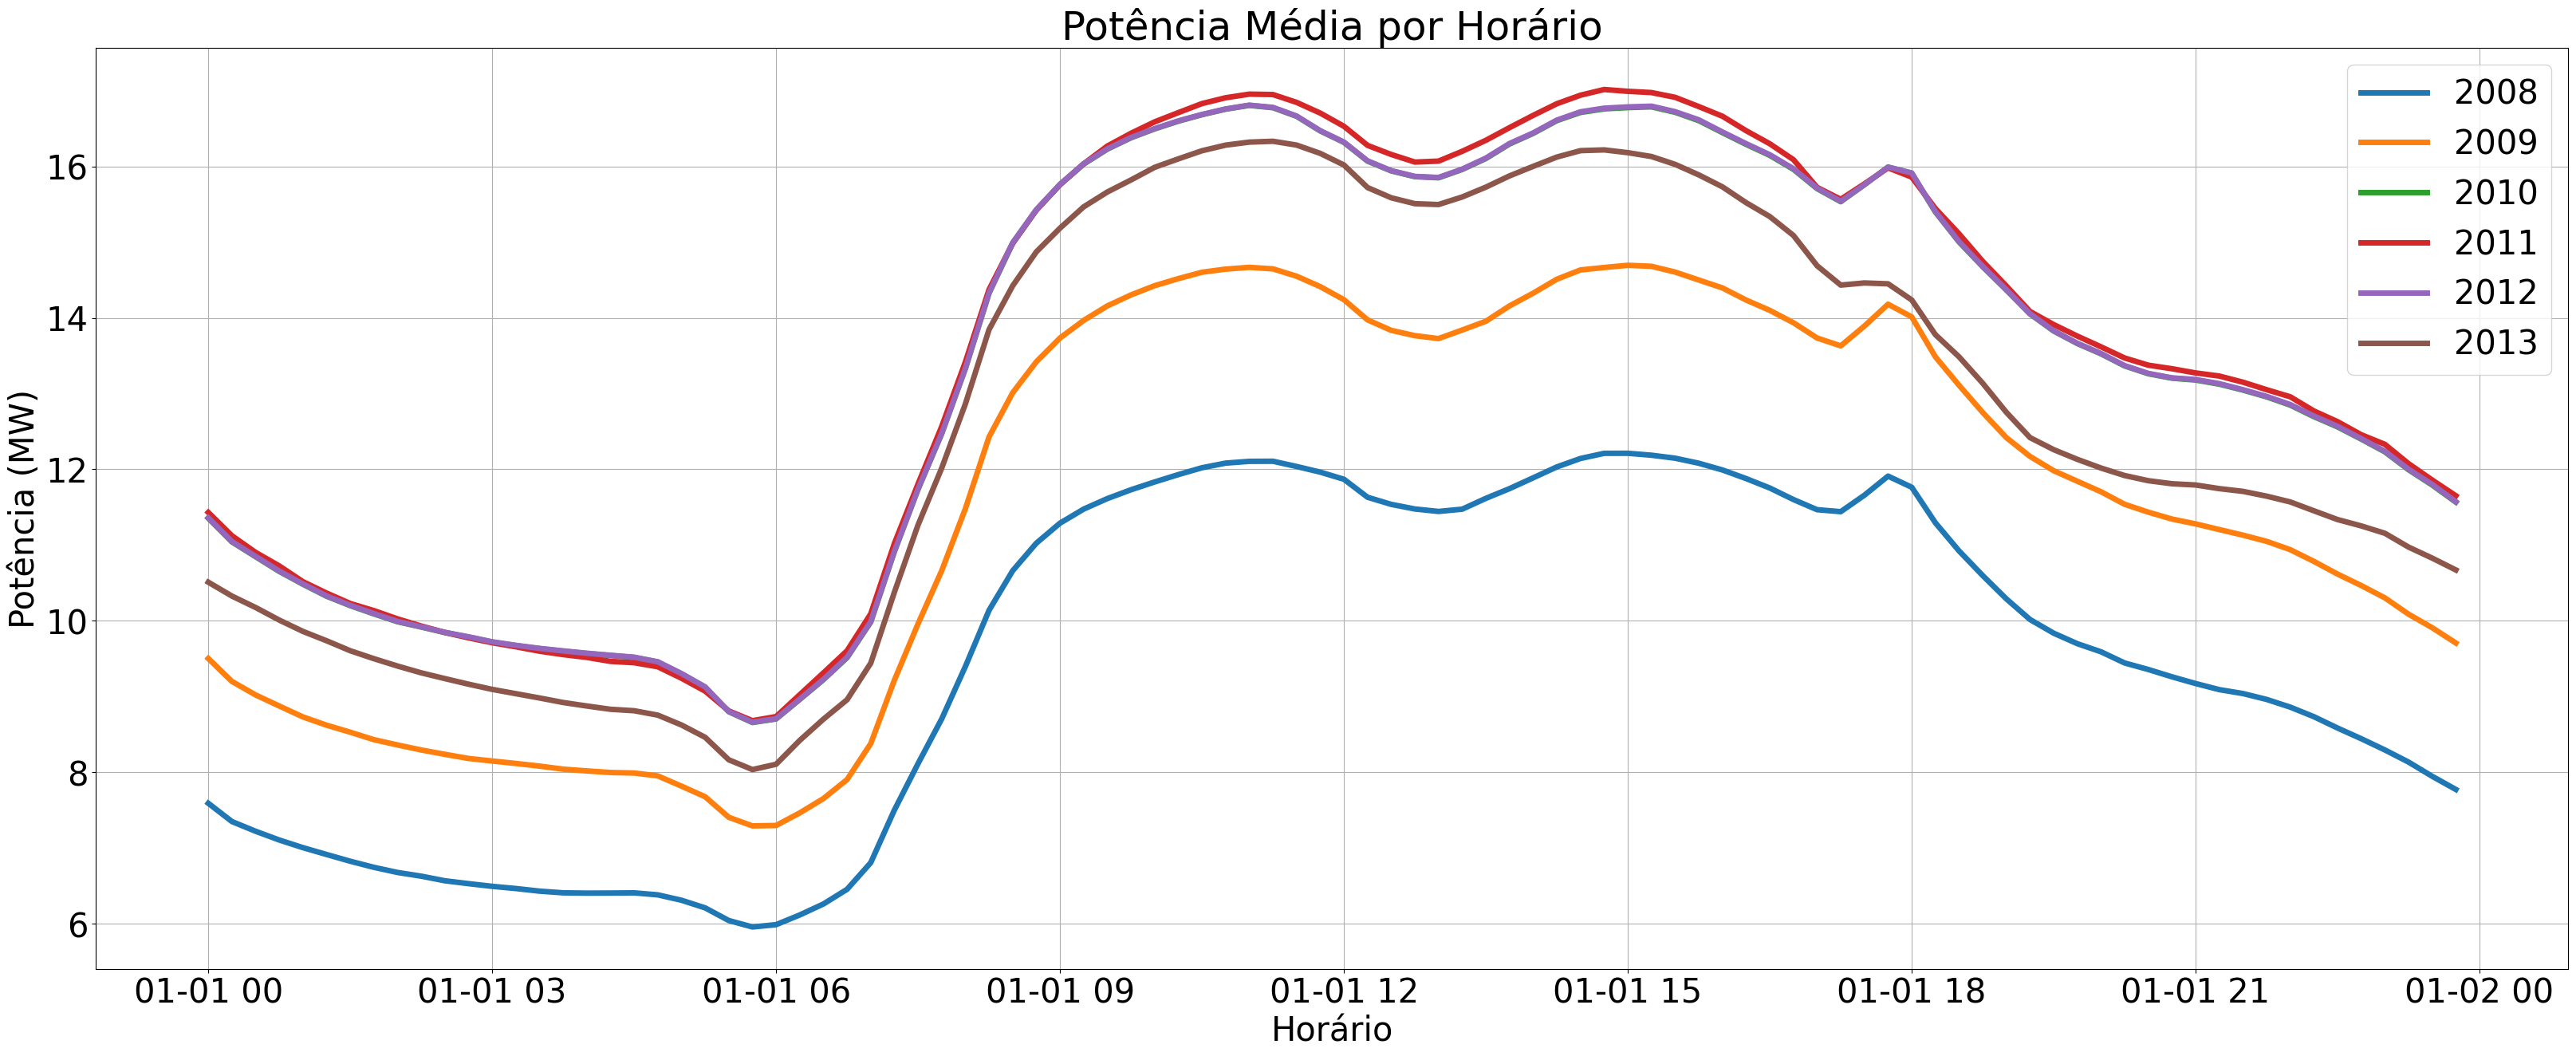

In [30]:
data['year'] = [x.year for x in data.index]
plt.figure(figsize=(40,15), dpi=100)
plt.rc('font', size=30)
plt.grid(True)
perfil_horario_por_ano = pd.DataFrame(index=pd.date_range(start ='2018-01-01 00:00:00',end ='2018-01-01 23:59:59', freq ='15min'))

for y in range(data.index.min().year, data.index.max().year+1):

    _aux = data.groupby(by='year').get_group(y)
    _means = list()

    for h in range(0, 24):
        for m in range(0,60,15):
            _means.append(_aux.groupby(by='hour:minute').get_group(f'{h}:{m}')['POTENCIA'].mean())

    perfil_horario_por_ano[f'POTENCIA_media_{y}'] = _means
    plt.plot(perfil_horario_por_ano[f'POTENCIA_media_{y}'], lw=5, label=f'{y}') # color='b',

plt.xlabel('Horário')
plt.ylabel('Potência (MW)')
plt.title('Potência Média por Horário')
plt.legend()

In [31]:
perfil_horario_por_ano.head()

POTENCIA_media_2008  POTENCIA_media_2009  \
2018-01-01 00:00:00             7.592093             9.503147   
2018-01-01 00:15:00             7.350596             9.200296   
2018-01-01 00:30:00             7.222600             9.022254   
2018-01-01 00:45:00             7.107050             8.875907   
2018-01-01 01:00:00             7.006152             8.731974   

                     POTENCIA_media_2010  POTENCIA_media_2011  \
2018-01-01 00:00:00            11.355303            11.431796   
2018-01-01 00:15:00            11.042038            11.123624   
2018-01-01 00:30:00            10.847060            10.903945   
2018-01-01 00:45:00            10.652439            10.725568   
2018-01-01 01:00:00            10.483434            10.517602   

                     POTENCIA_media_2012  POTENCIA_media_2013  
2018-01-01 00:00:00            11.359250            10.510732  
2018-01-01 00:15:00            11.046841            10.327344  
2018-01-01 00:30:00            10.851303            10.176423  
2018-01-01 00:45:00            10.657214            10.010364  
2018-01-01 01:00:00            10.487851             9.861017

### Por ano e dia da semana

In [32]:
data.columns

Index(['POTENCIA', 'weekday', 'hour:minute', 'year'], dtype='object')

In [33]:
perfil_horario_por_ano_por_dia_da_semana = pd.DataFrame(index=pd.date_range(start ='2018-01-01 00:00:00',end ='2018-01-01 23:59:59', freq ='15min'))

for y in range(data.index.min().year, data.index.max().year+1):

    _aux = data.groupby(by='year').get_group(y)

    for dia_da_semana in range(0,7):

        _means = list()
        _aux_weekday = _aux.groupby(by='weekday').get_group(dia_da_semana)

        for h in range(0, 24):
            for m in range(0,60,15):

                _means.append(_aux_weekday.groupby(by='hour:minute').get_group(f'{h}:{m}')['POTENCIA'].mean())

        perfil_horario_por_ano_por_dia_da_semana[ f'POTENCIA_media_{dia_da_semana}_{y}'] = _means

perfil_horario_por_ano_por_dia_da_semana.head()

POTENCIA_media_0_2008  POTENCIA_media_1_2008  \
2018-01-01 00:00:00               7.285577               7.520755   
2018-01-01 00:15:00               7.064717               7.276415   
2018-01-01 00:30:00               6.974626               7.139623   
2018-01-01 00:45:00               6.874919               7.002830   
2018-01-01 01:00:00               6.763674               6.930189   

                     POTENCIA_media_2_2008  POTENCIA_media_3_2008  \
2018-01-01 00:00:00               7.616793               7.691253   
2018-01-01 00:15:00               7.417359               7.407652   
2018-01-01 00:30:00               7.256604               7.276456   
2018-01-01 00:45:00               7.138679               7.189490   
2018-01-01 01:00:00               7.029245               7.051562   

                     POTENCIA_media_4_2008  POTENCIA_media_5_2008  \
2018-01-01 00:00:00               7.693526               7.747500   
2018-01-01 00:15:00               7.444708               7.473269   
2018-01-01 00:30:00               7.329865               7.335577   
2018-01-01 00:45:00               7.193867               7.220192   
2018-01-01 01:00:00               7.110755               7.114423   

                     POTENCIA_media_6_2008  POTENCIA_media_0_2009  \
2018-01-01 00:00:00               7.590144               9.155769   
2018-01-01 00:15:00               7.370192               8.928846   
2018-01-01 00:30:00               7.246394               8.766346   
2018-01-01 00:45:00               7.130769               8.629808   
2018-01-01 01:00:00               7.044231               8.456731   

                     POTENCIA_media_1_2009  POTENCIA_media_2_2009  ...  \
2018-01-01 00:00:00               9.476072               9.596875  ...   
2018-01-01 00:15:00               9.130026               9.268870  ...   
2018-01-01 00:30:00               8.947005               9.086058  ...   
2018-01-01 00:45:00               8.803767               8.960938  ...   
2018-01-01 01:00:00               8.660102               8.795433  ...   

                     POTENCIA_media_4_2012  POTENCIA_media_5_2012  \
2018-01-01 00:00:00              11.544465              11.475437   
2018-01-01 00:15:00              11.229456              11.174213   
2018-01-01 00:30:00              11.037523              10.972989   
2018-01-01 00:45:00              10.795591              10.799650   
2018-01-01 01:00:00              10.628659              10.608042   

                     POTENCIA_media_6_2012  POTENCIA_media_0_2013  \
2018-01-01 00:00:00              11.156604              10.094231   
2018-01-01 00:15:00              10.874528               9.921154   
2018-01-01 00:30:00              10.718868               9.765385   
2018-01-01 00:45:00              10.577358               9.623077   
2018-01-01 01:00:00              10.424528               9.480769   

                     POTENCIA_media_1_2013  POTENCIA_media_2_2013  \
2018-01-01 00:00:00              10.725472              10.483030   
2018-01-01 00:15:00              10.497666              10.307820   
2018-01-01 00:30:00              10.336842              10.152801   
2018-01-01 00:45:00              10.176018               9.968937   
2018-01-01 01:00:00               9.998212               9.815841   

                     POTENCIA_media_3_2013  POTENCIA_media_4_2013  \
2018-01-01 00:00:00              10.768269              10.765429   
2018-01-01 00:15:00              10.557632              10.552146   
2018-01-01 00:30:00              10.384494              10.409056   
2018-01-01 00:45:00              10.201741              10.214042   
2018-01-01 01:00:00              10.008411              10.096913   

                     POTENCIA_media_5_2013  POTENCIA_media_6_2013  
2018-01-01 00:00:00              10.556559              10.178005  
2018-01-01 00:15:00              10.394747              10.056971  
2018-01-01 00:30:00              10.248320          

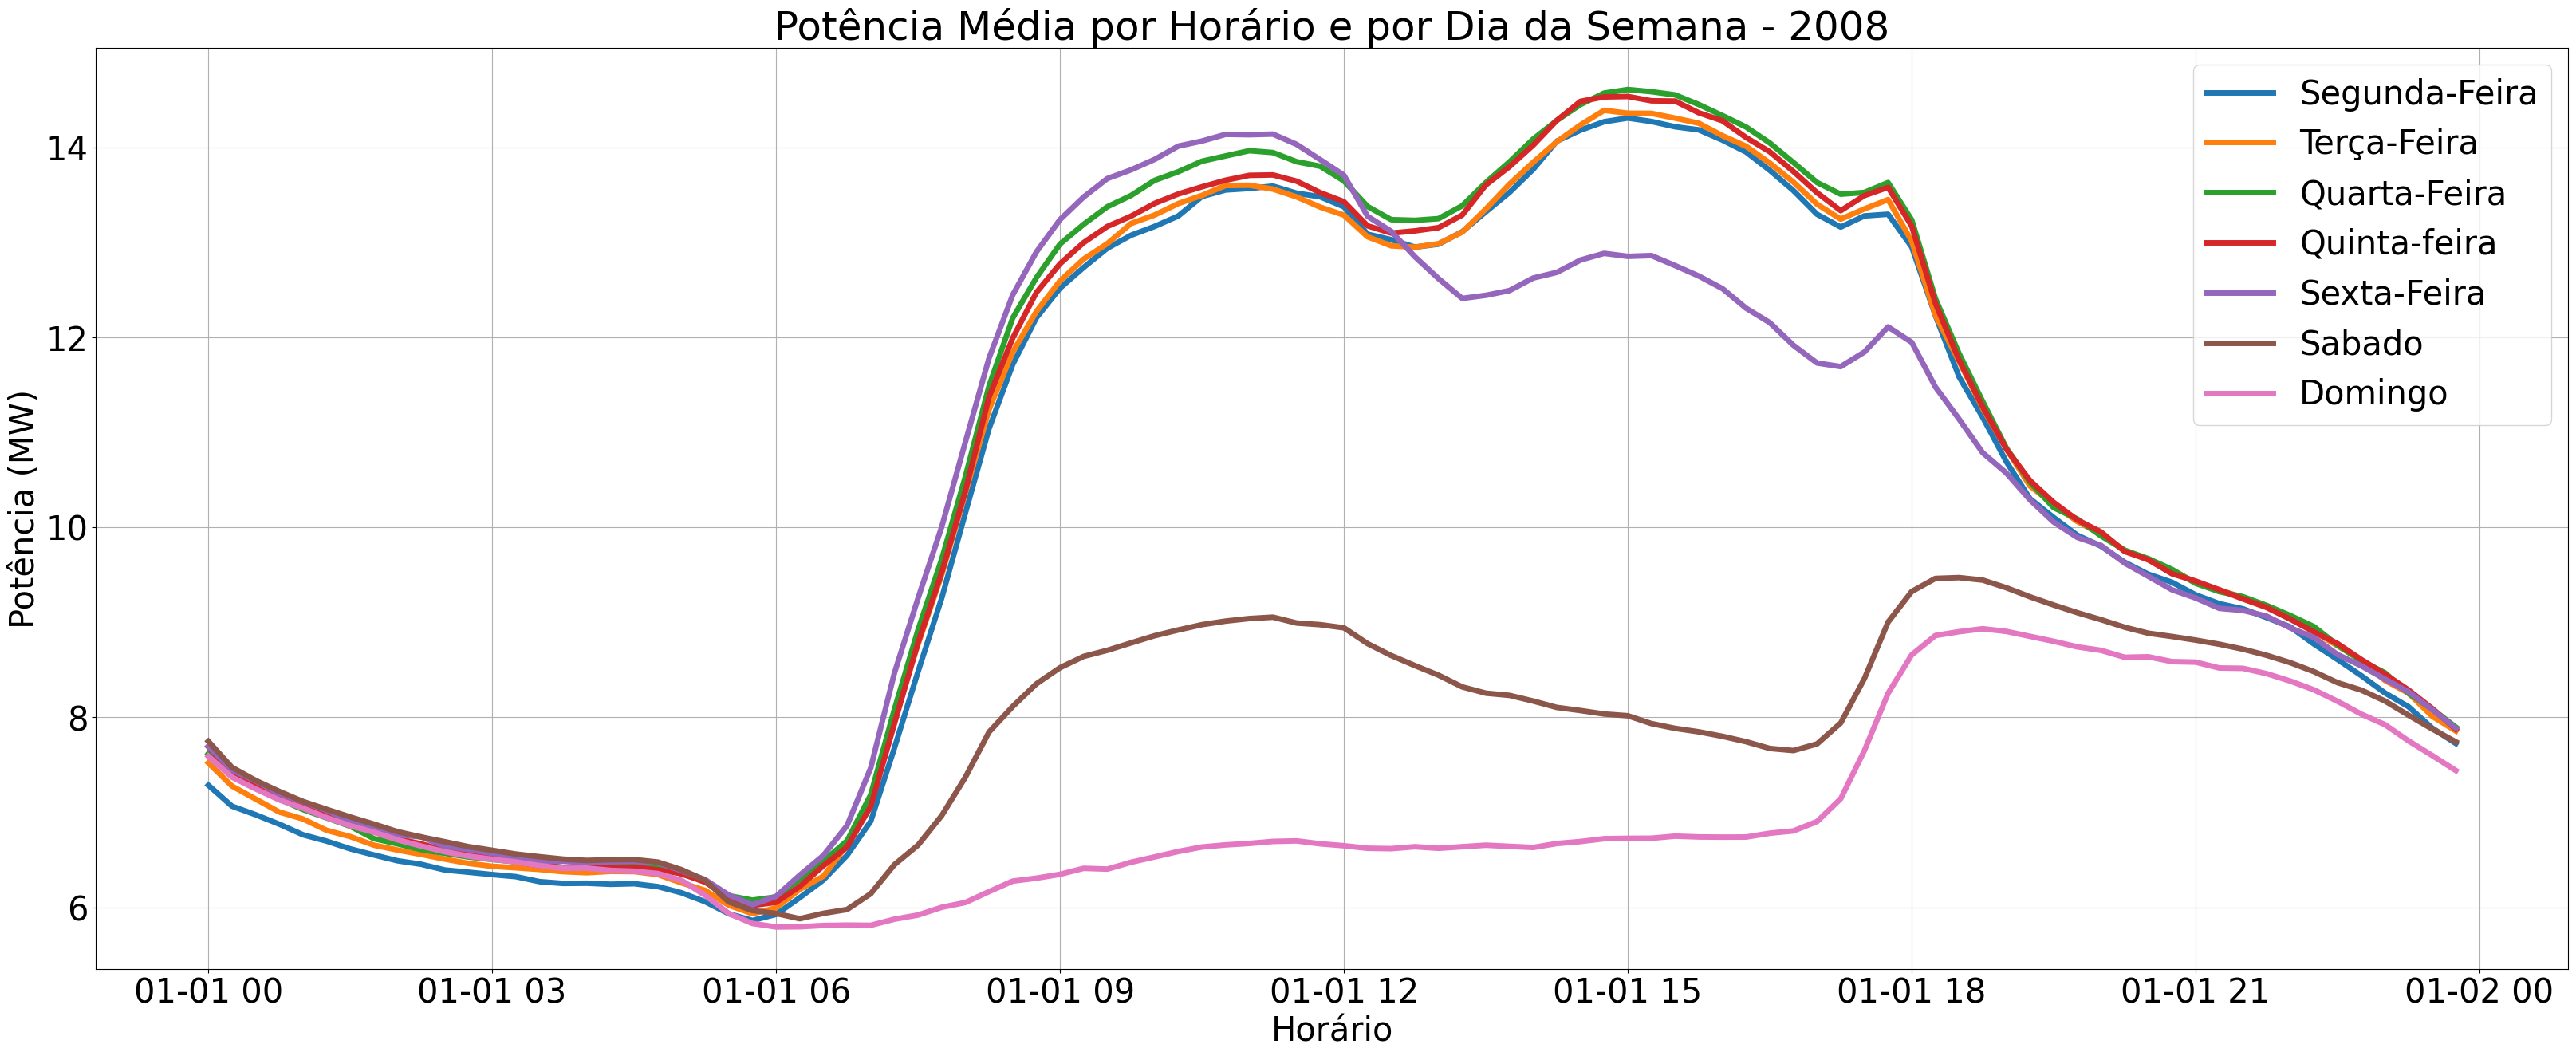

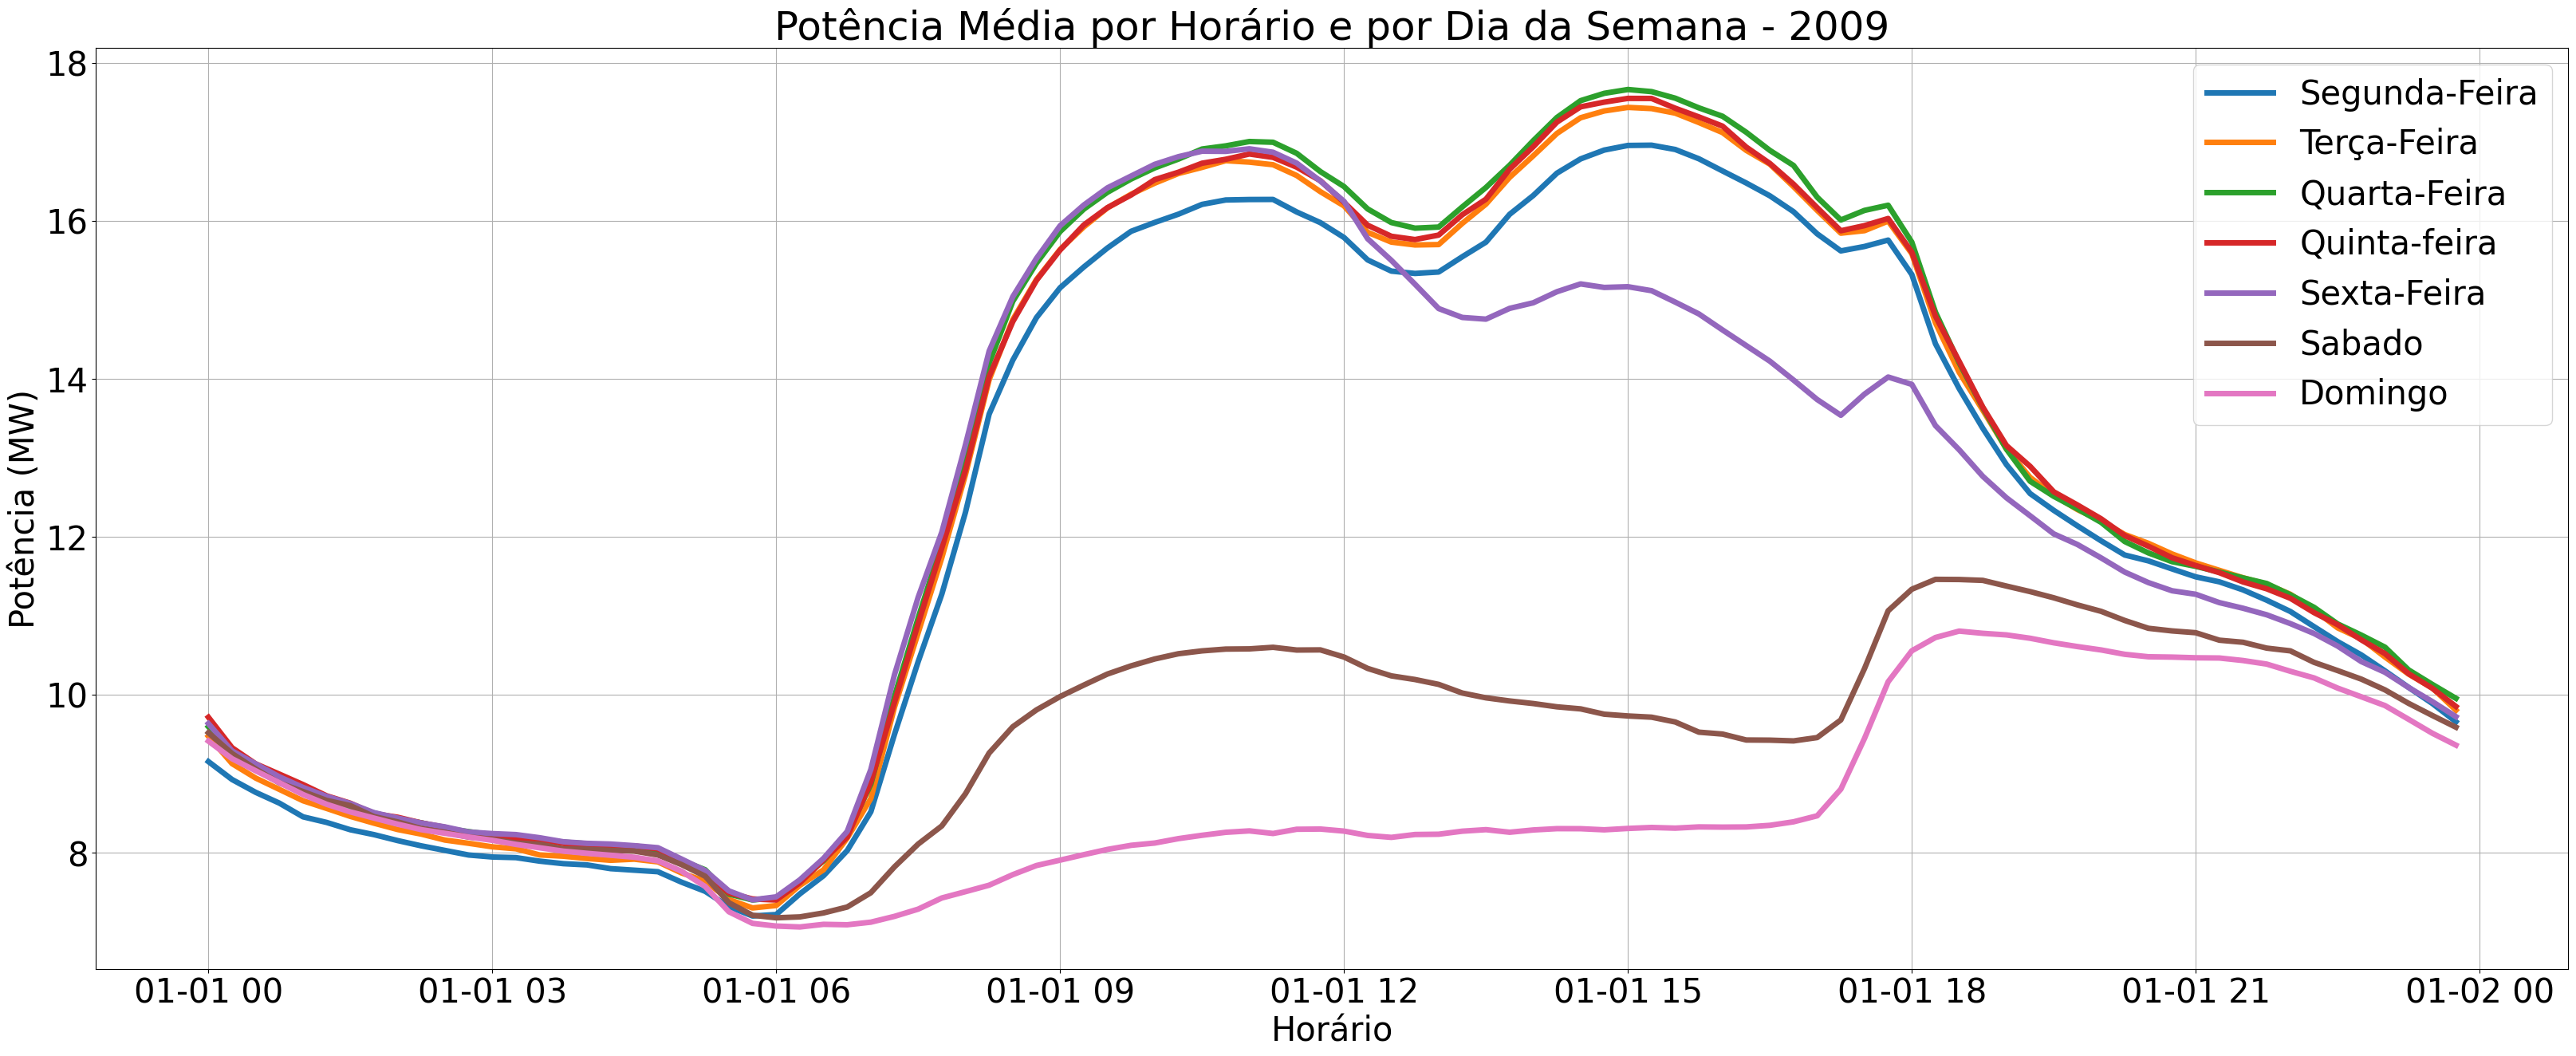

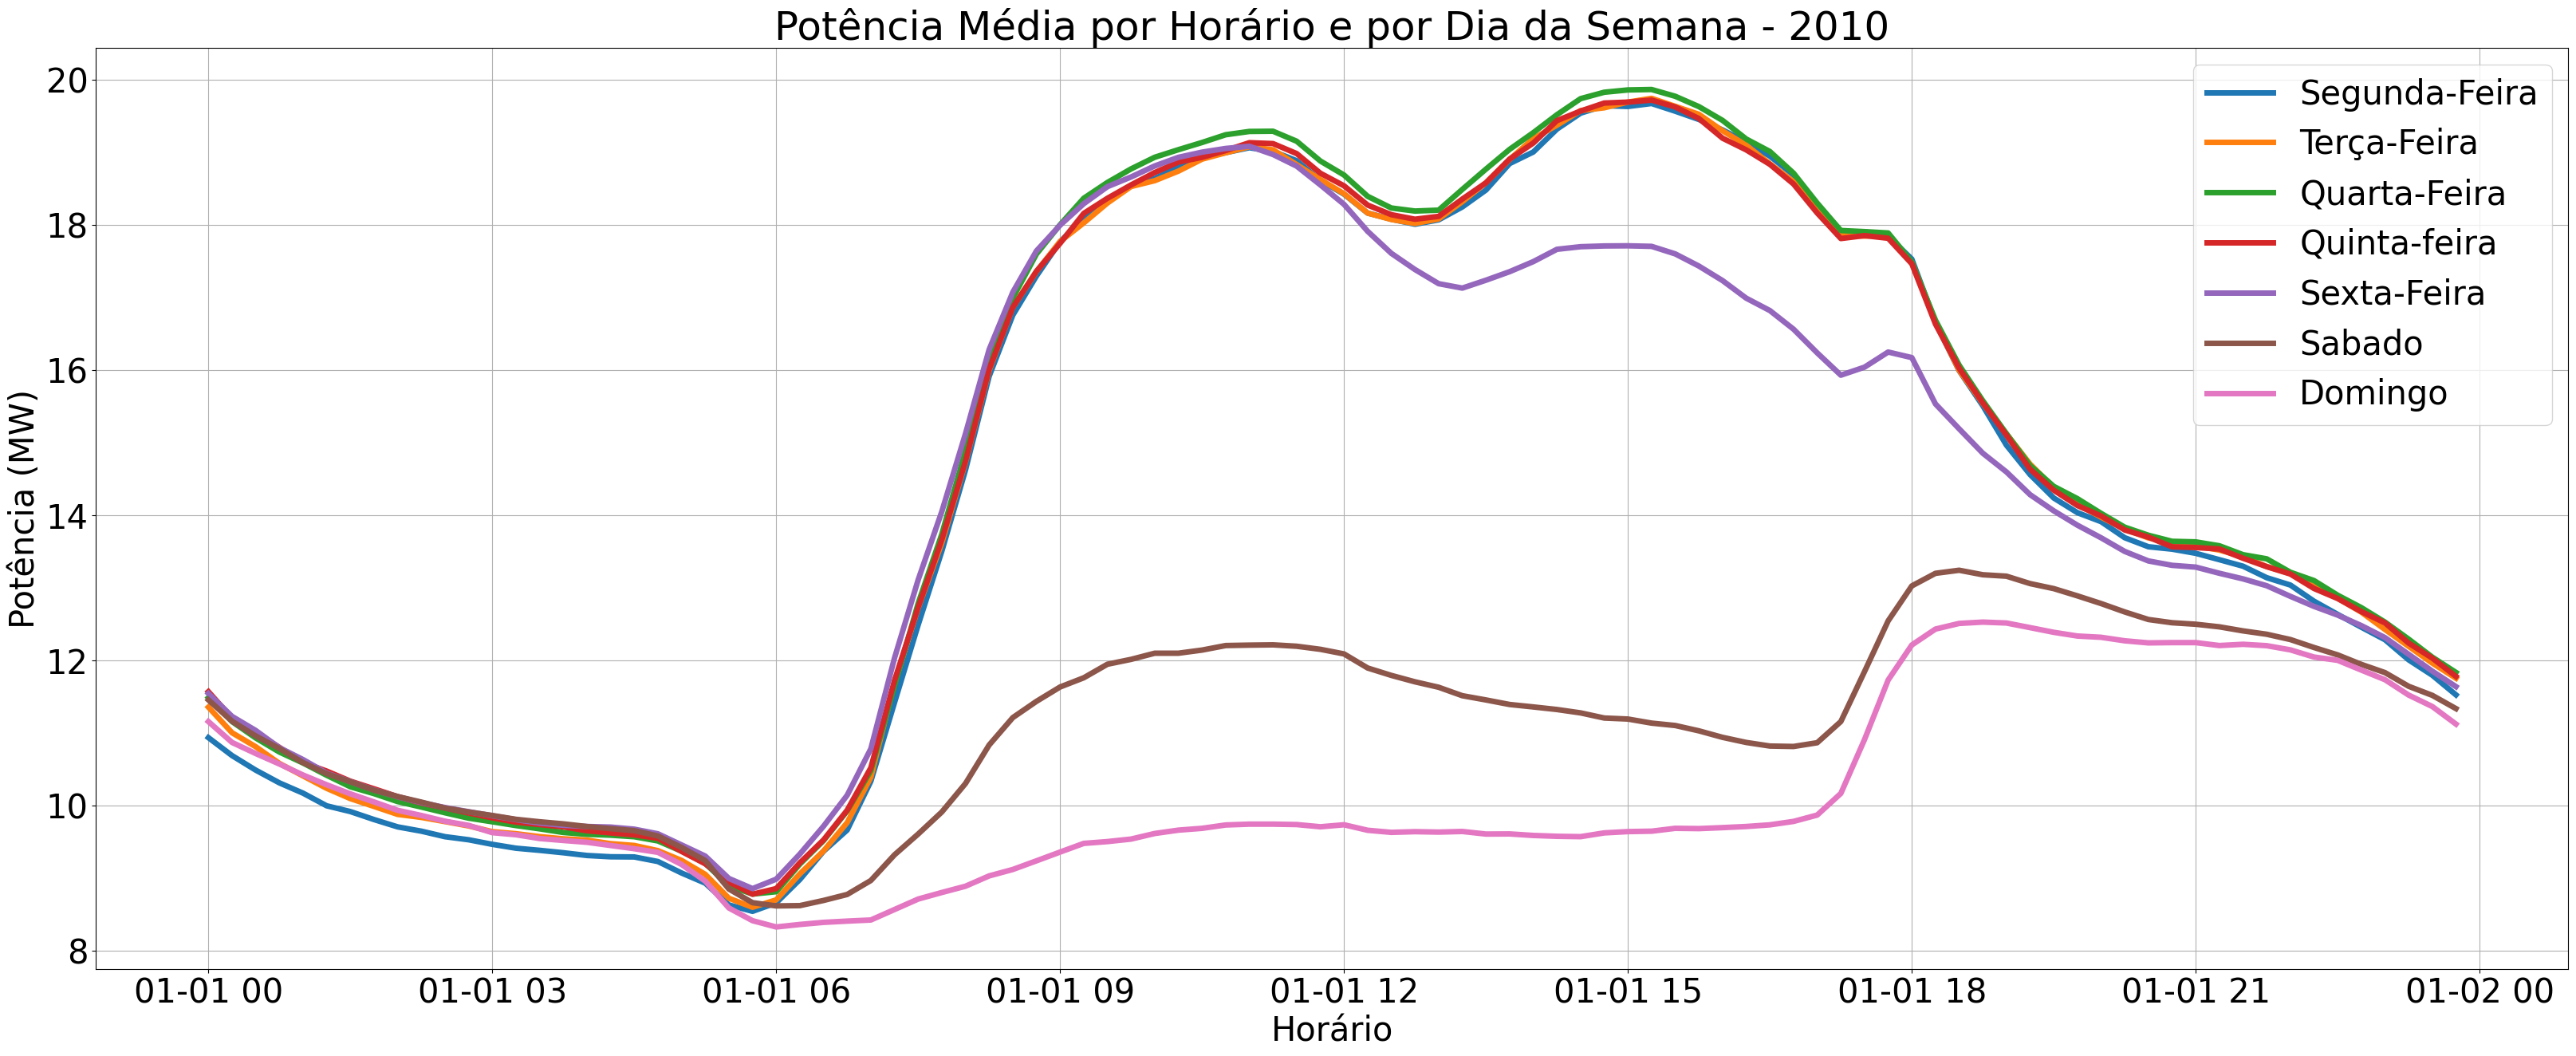

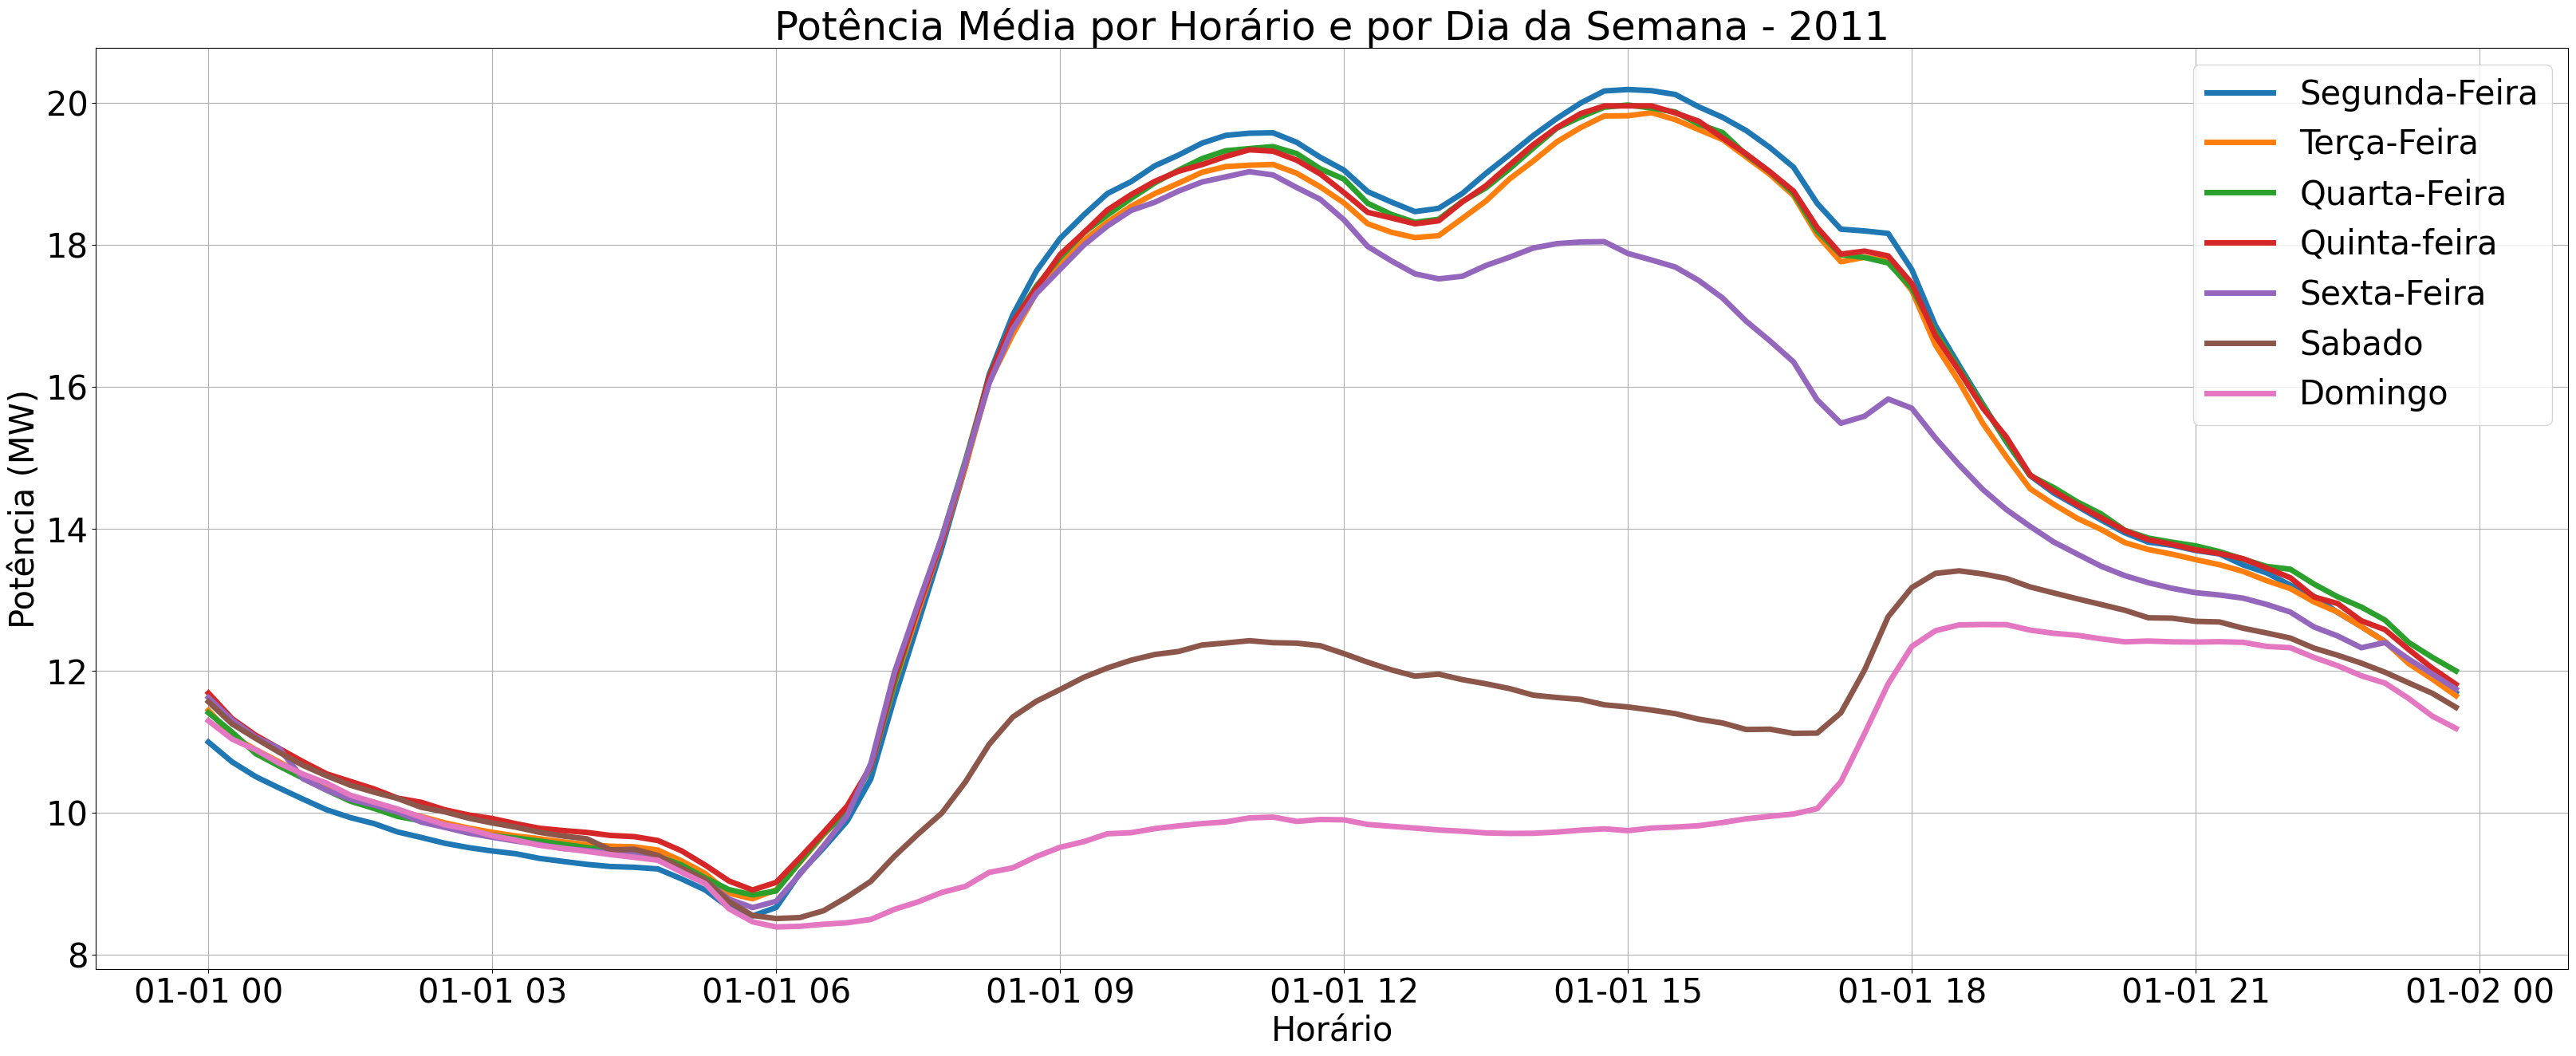

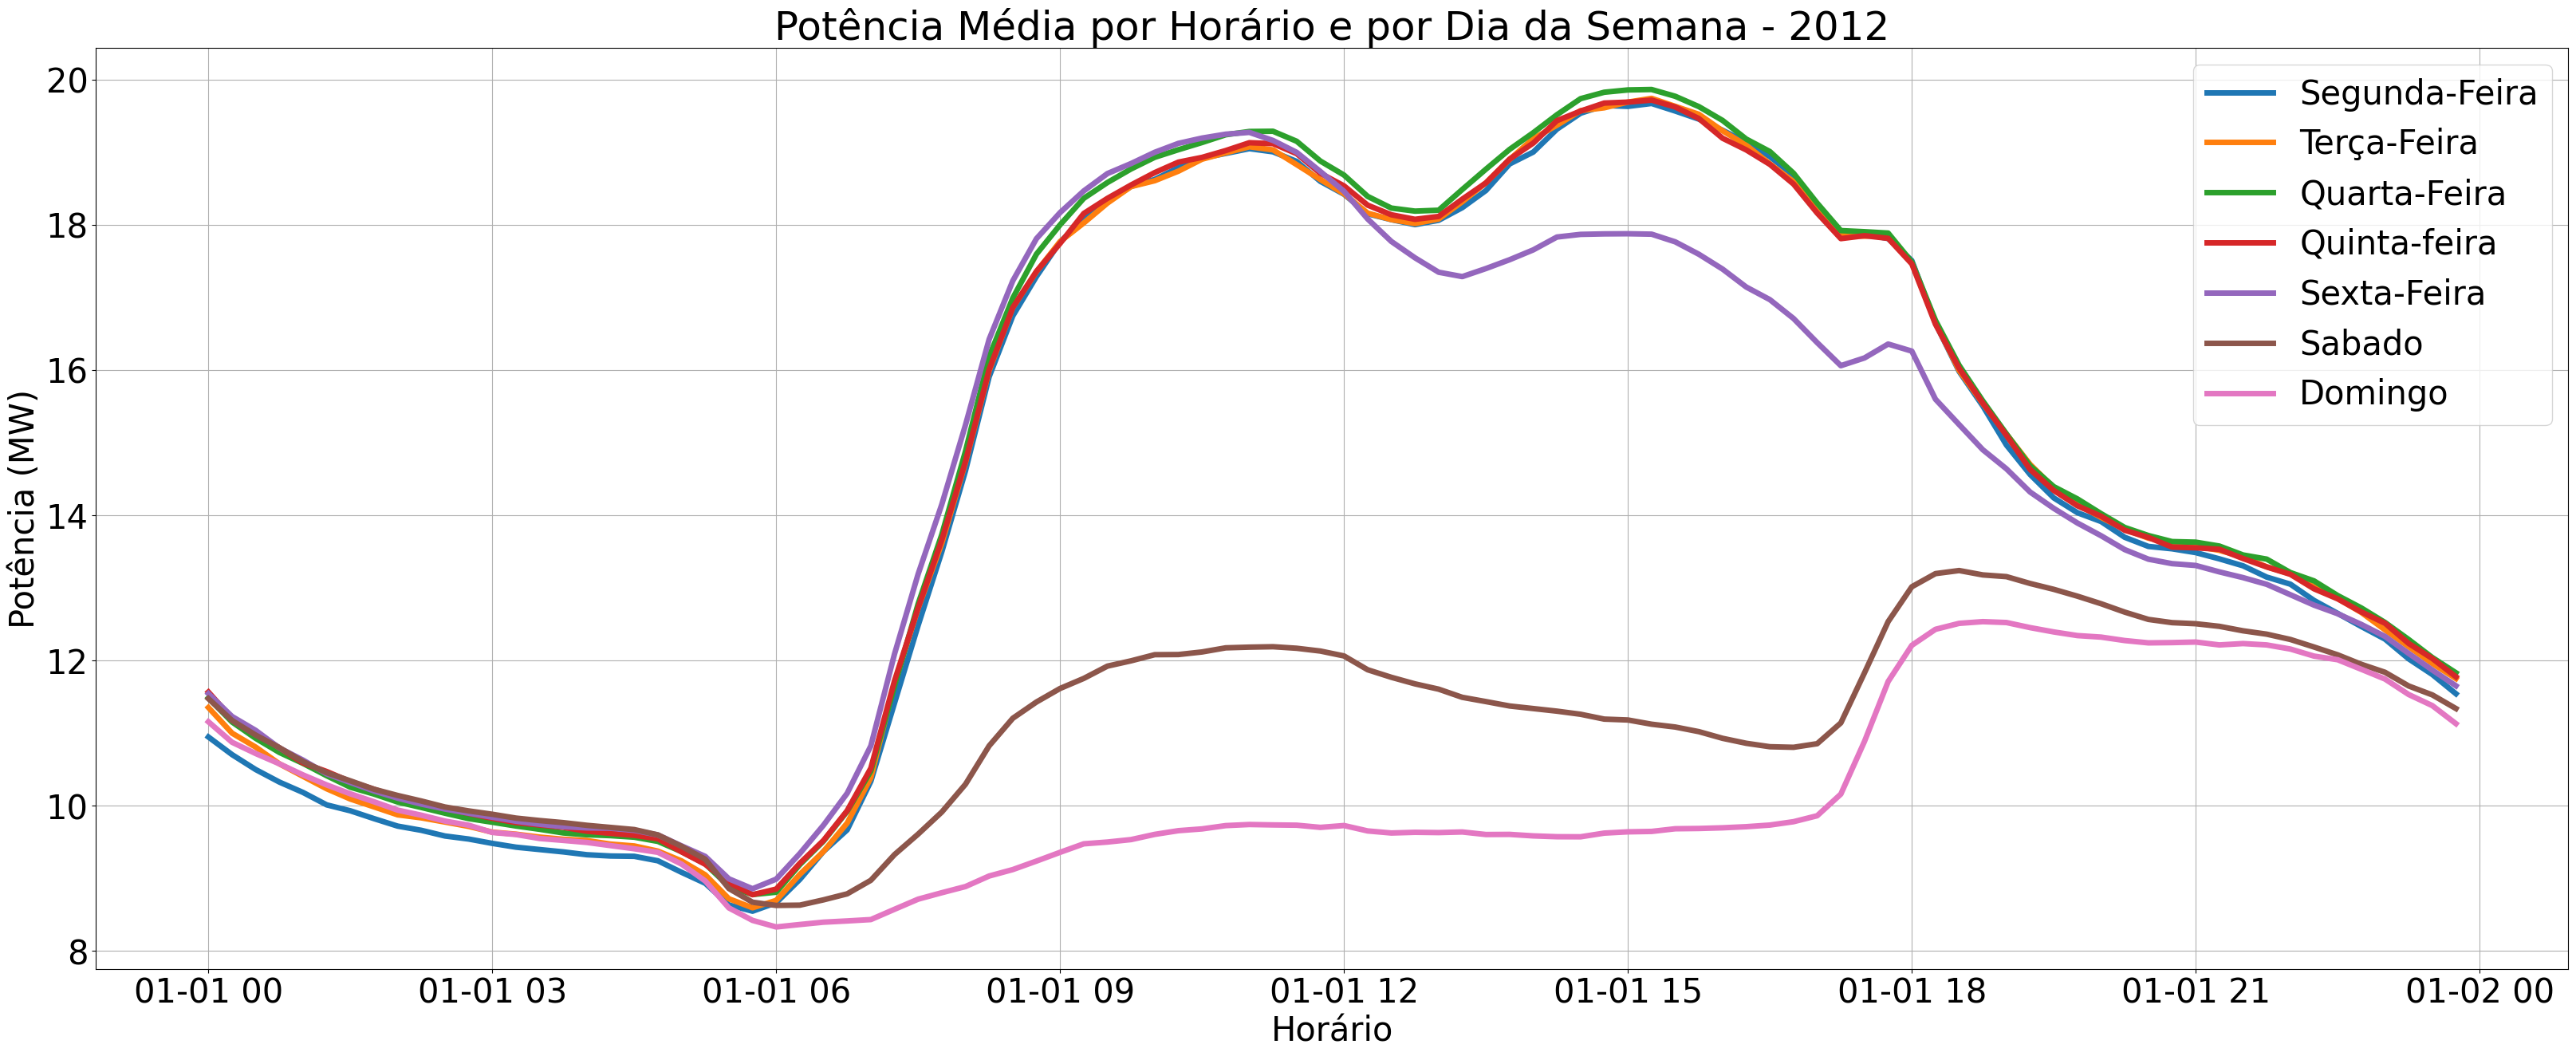

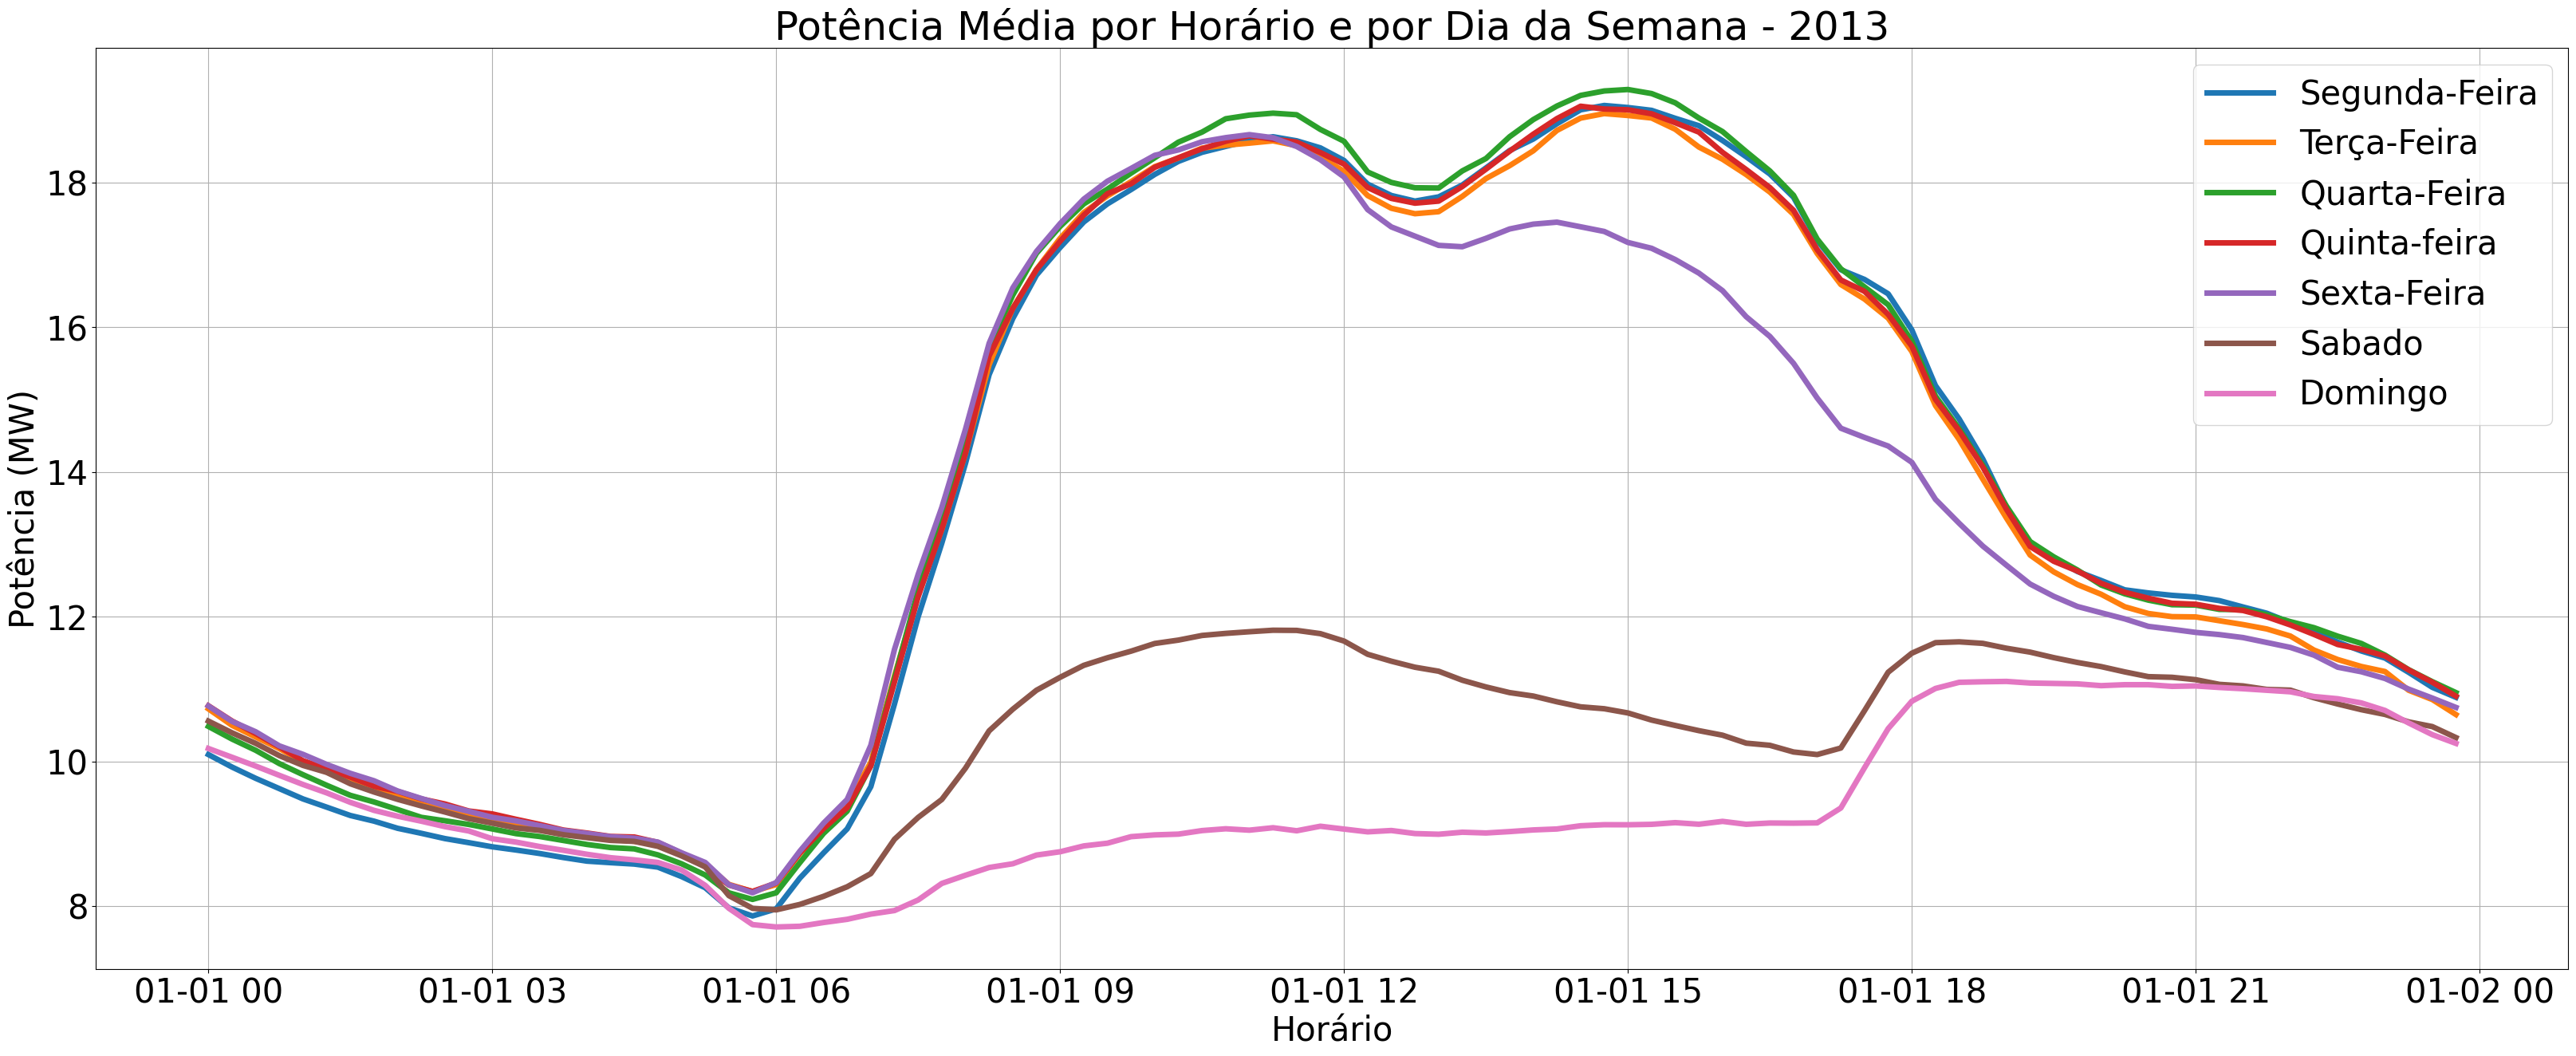

In [34]:
labels = ['Segunda-Feira','Terça-Feira','Quarta-Feira','Quinta-feira','Sexta-Feira','Sabado','Domingo']

for y in range(data.index.min().year, data.index.max().year+1):

    plt.figure(figsize=(40,15), dpi=100)

    for dia_da_semana in range(0,7):
        plt.plot(perfil_horario_por_ano_por_dia_da_semana[[f'POTENCIA_media_{dia_da_semana}_{y}']], lw=5, label=f'{labels[dia_da_semana]}')

    plt.rc('font', size=30)
    plt.grid(True)
    plt.xlabel('Horário')
    plt.ylabel('Potência (MW)')
    plt.title(f'Potência Média por Horário e por Dia da Semana - {y}')
    plt.legend()

## Criando o banco de dados para treinamento e teste da RNA

In [51]:
data_semanal = max_semanal.copy()
data_semanal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2008-01-06 to 2014-01-05
Freq: W-SUN
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   POTENCIA      314 non-null    float64
 1   ENERGIA       314 non-null    object 
 2   TAXA_ENERGIA  314 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.8+ KB


In [52]:
data_semanal.reset_index(inplace=True)

n_anteriores = 4 # 4 amostras anteriores, o que corresponde a 1 hora de dados
n_posteriores = 2 # 1 amostra posterior, o que corresponde a valores 30 minutos no futuro

for i in range(1,n_anteriores+1):
    data_semanal[f'POTENCIA(K-{i})'] = data_semanal['POTENCIA'].shift(i)
    data_semanal[f'ENERGIA(K-{i})'] = data_semanal['ENERGIA'].shift(i)
    data_semanal[f'TAXA_ENERGIA(K-{i})'] = data_semanal['TAXA_ENERGIA'].shift(i)
    
for i in range(-1,-(n_posteriores+1),-1):
    data_semanal[f'POTENCIA(K+{-i})'] = data_semanal['POTENCIA'].shift(i)

data_semanal.columns

Index(['TEMPO', 'POTENCIA', 'ENERGIA', 'TAXA_ENERGIA', 'POTENCIA(K-1)',
       'ENERGIA(K-1)', 'TAXA_ENERGIA(K-1)', 'POTENCIA(K-2)', 'ENERGIA(K-2)',
       'TAXA_ENERGIA(K-2)', 'POTENCIA(K-3)', 'ENERGIA(K-3)',
       'TAXA_ENERGIA(K-3)', 'POTENCIA(K-4)', 'ENERGIA(K-4)',
       'TAXA_ENERGIA(K-4)', 'POTENCIA(K+1)', 'POTENCIA(K+2)'],
      dtype='object')

In [53]:
# data_semanal['week_number'] = data_semanal.TEMPO.map(lambda x: x.isocalendar().week)
# data_semanal['mean_last_four_weeks'] = data_semanal[['POTENCIA(K-4)', 'POTENCIA(K-3)', 'POTENCIA(K-2)', 'POTENCIA(K-1)']].mean(axis=1)
# data_semanal['mean_last_two_weeks'] = data_semanal[['POTENCIA(K-2)', 'POTENCIA(K-1)']].mean(axis=1)
data_semanal.dropna(inplace=True)
data_semanal.drop(columns=['index','TEMPO'],inplace=True, errors='ignore')
data_semanal.head()

POTENCIA  ENERGIA  TAXA_ENERGIA  POTENCIA(K-1) ENERGIA(K-1)  \
4  16.000000   265.95         4.000      15.800000     266.2225   
5  16.299999  269.575         4.075      16.000000       265.95   
6  16.700001  279.575         4.175      16.299999      269.575   
7  17.000000   279.55         4.250      16.700001      279.575   
8  17.100000  284.825         4.275      17.000000       279.55   

   TAXA_ENERGIA(K-1)  POTENCIA(K-2) ENERGIA(K-2)  TAXA_ENERGIA(K-2)  \
4              3.950      14.600000     248.2375              3.650   
5              4.000      15.800000     266.2225              3.950   
6              4.075      16.000000       265.95              4.000   
7              4.175      16.299999      269.575              4.075   
8              4.250      16.700001      279.575              4.175   

   POTENCIA(K-3) ENERGIA(K-3)  TAXA_ENERGIA(K-3)  POTENCIA(K-4) ENERGIA(K-4)  \
4      15.900000   266.475001              3.975           13.9   243.062499   
5      14.600000     248.2375              3.650           15.9   266.475001   
6      15.800000     266.2225              3.950           14.6     248.2375   
7      16.000000       265.95              4.000           15.8     266.2225   
8      16.299999      269.575              4.075           16.0       265.95   

   TAXA_ENERGIA(K-4)  POTENCIA(K+1)  POTENCIA(K+2)  
4              3.475      16.299999      16.700001  
5              3.975      16.700001      17.000000  
6              3.650      17.000000      17.100000  
7              3.950      17.100000      17.299999  
8              4.000      17.299999      17.400000

#### Correlação dos dados de entrada com os dados de saída

In [55]:
corr_k1 = np.abs(data_semanal.corr().filter(items=['POTENCIA(K+1)']).dropna()).T.drop(columns=['POTENCIA(K+1)']).sort_values(axis=1,by='POTENCIA(K+1)',ascending=False)
corr_k2 = np.abs(data_semanal.corr().filter(items=['POTENCIA(K+2)']).dropna()).T.drop(columns=['POTENCIA(K+2)']).sort_values(axis=1,by='POTENCIA(K+2)',ascending=False)
corr_k1.loc[:,corr_k1.columns]

ENERGIA  TAXA_ENERGIA  POTENCIA  POTENCIA(K+2)  ENERGIA(K-1)  \
POTENCIA(K+1)  0.936873      0.936195  0.936195       0.923649      0.908042   

               TAXA_ENERGIA(K-1)  POTENCIA(K-1)  ENERGIA(K-2)  POTENCIA(K-2)  \
POTENCIA(K+1)           0.903429       0.903429      0.887456       0.873995   

               TAXA_ENERGIA(K-2)  ENERGIA(K-3)  TAXA_ENERGIA(K-3)  \
POTENCIA(K+1)           0.873995      0.863717           0.846929   

               POTENCIA(K-3)  ENERGIA(K-4)  POTENCIA(K-4)  TAXA_ENERGIA(K-4)  
POTENCIA(K+1)       0.846929      0.836535       0.812574           0.812574

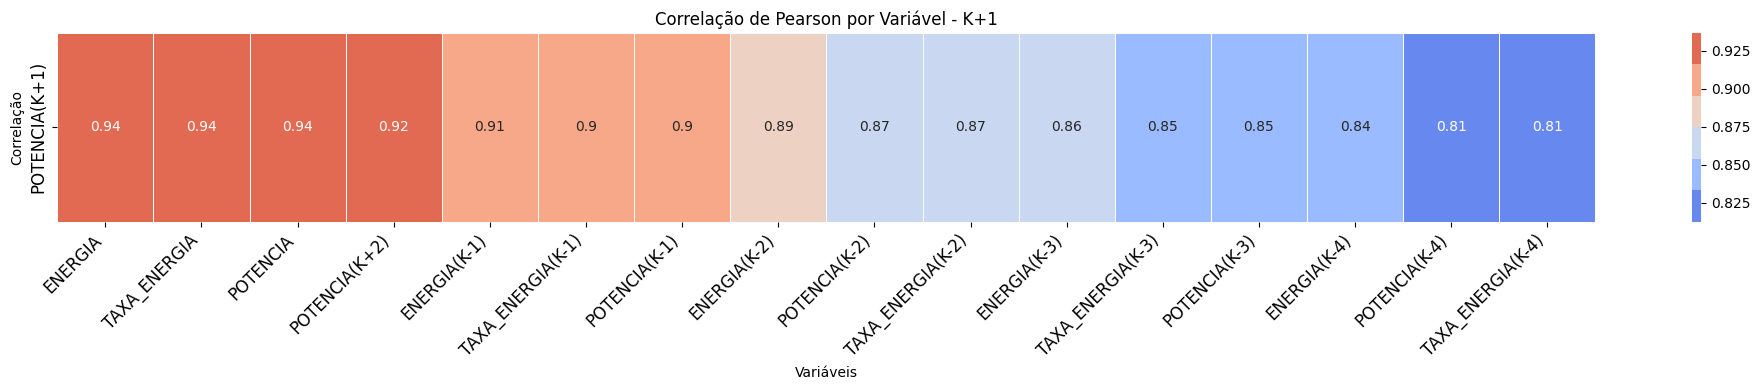

In [59]:
f, ax = plt.subplots(figsize=(20,4))

my_plot = sns.heatmap(
    corr_k1,
    # pd.DataFrame(corr_k1['POTENCIA(K+1)'].filter(items=corr_k1.columns)).T,
    cmap=sns.color_palette("coolwarm"),
    linewidths=0.5,
    annot=True
)

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)

#modify individual font size of elements
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Variáveis')
plt.ylabel('Correlação')
plt.title('Correlação de Pearson por Variável - K+1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

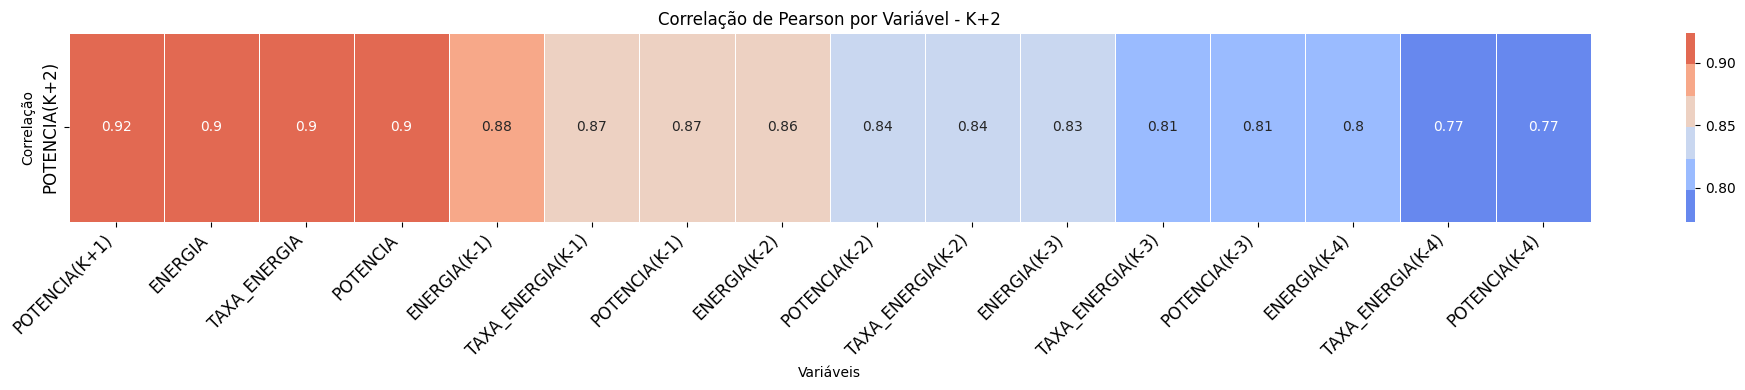

In [60]:
f, ax = plt.subplots(figsize=(20,4))

my_plot = sns.heatmap(
    corr_k2,
    # pd.DataFrame(corr_k1['POTENCIA(K+1)'].filter(items=corr_k1.columns)).T,
    cmap=sns.color_palette("coolwarm"),
    linewidths=0.5,
    annot=True
)

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)

#modify individual font size of elements
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Variáveis')
plt.ylabel('Correlação')
plt.title('Correlação de Pearson por Variável - K+2')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [61]:
data_semanal.to_csv('data_semanal.csv', index=False)
data_semanal.to_parquet('data_semanal.parquet', index=False)